In [1]:
# ========================================
# COMPREHENSIVE FEATURE SELECTION PIPELINE
# State-of-the-Art Methods for Credit Risk XAI
# ========================================

import sys
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

import shap
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
from sklearn.calibration import calibration_curve
from sklearn.feature_selection import RFECV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

# Project imports
PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

from credit_risk_xai.modeling.train import DEFAULT_PARAMS, FEATURES_FOR_MODEL
from credit_risk_xai.config import FEATURE_CACHE_PATH, FEATURE_GROUPS_BY_SOURCE
from credit_risk_xai.features.engineer import prepare_modeling_data
from credit_risk_xai.modeling.train import run_lightgbm_training

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Imports complete")
print(f"✓ Total features in config: {len(FEATURES_FOR_MODEL)}")

✓ Imports complete
✓ Total features in config: 65


In [2]:
# ========================================
# PHASE 1: DATA LOADING & BASELINE MODEL
# ========================================

print("Loading data...")
df = pd.read_parquet(FEATURE_CACHE_PATH)
df = df[(df["ser_aktiv"] == 1) & (df["sme_category"].isin(["Small", "Medium"])) & (df["knc_kncfall"] == 1)]
X, y = prepare_modeling_data(df)

print(f"\n{'='*60}")
print(f"DATASET SUMMARY")
print(f"{'='*60}")
print(f"Features: {X.shape[1]}")
print(f"Samples: {len(X):,}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Imbalance ratio: {(y==0).sum()/(y==1).sum():.1f}:1")
print(f"{'='*60}\n")

# Store original feature list
ORIGINAL_FEATURES = X.columns.tolist()
print(f"Original feature set: {len(ORIGINAL_FEATURES)} features")

Loading data...

DATASET SUMMARY
Features: 65
Samples: 316,663
Target distribution:
target_next_year
0    310079
1      6584
Name: count, dtype: Int64
Imbalance ratio: 47.1:1

Original feature set: 65 features


In [3]:
# Train baseline model on all 65 features
print("Training baseline model on all 65 features...")
print(f"{'='*60}\n")

baseline_results = run_lightgbm_training(
    X=X,
    y=y,
    dataset_description="Baseline - All 65 Features",
    use_wandb=False,
)

# Extract baseline metrics
baseline_model = baseline_results["model"]
baseline_X_train = baseline_results["X_train"]
baseline_X_val = baseline_results["X_val"]
baseline_y_train = baseline_results["y_train"]
baseline_y_val = baseline_results["y_val"]
baseline_y_pred_proba = baseline_results["y_val_proba"]

baseline_auc = roc_auc_score(baseline_y_val, baseline_y_pred_proba)
baseline_pr_auc = average_precision_score(baseline_y_val, baseline_y_pred_proba)

print(f"\n{'='*60}")
print(f"BASELINE PERFORMANCE (65 features)")
print(f"{'='*60}")
print(f"ROC-AUC:  {baseline_auc:.4f}")
print(f"PR-AUC:   {baseline_pr_auc:.4f}")
print(f"{'='*60}\n")

Training baseline model on all 65 features...

[50]	training's binary_logloss: 0.0449643	valid_1's binary_logloss: 0.0497652
[100]	training's binary_logloss: 0.0383204	valid_1's binary_logloss: 0.0471577
[150]	training's binary_logloss: 0.033999	valid_1's binary_logloss: 0.046424
[200]	training's binary_logloss: 0.0308663	valid_1's binary_logloss: 0.0462007
[250]	training's binary_logloss: 0.0282493	valid_1's binary_logloss: 0.0459948
[300]	training's binary_logloss: 0.0259935	valid_1's binary_logloss: 0.0460096
[350]	training's binary_logloss: 0.0241865	valid_1's binary_logloss: 0.0459876

BASELINE PERFORMANCE (65 features)
ROC-AUC:  0.9527
PR-AUC:   0.6487



In [11]:
# Check data types and standardize before VIF calculation
print("Checking data types...")
print(f"\nData types:\n{baseline_X_train.dtypes.value_counts()}")

# Standardize all columns to float64 for VIF calculation
print("\nStandardizing all features to float64...")
baseline_X_train_clean = baseline_X_train.copy()

for col in baseline_X_train_clean.columns:
    # Convert to numeric, handling nullable dtypes
    baseline_X_train_clean[col] = pd.to_numeric(baseline_X_train_clean[col], errors='coerce').astype(np.float64)

# Replace inf with nan
baseline_X_train_clean = baseline_X_train_clean.replace([np.inf, -np.inf], np.nan)

print(f"✓ All features converted to float64")
print(f"Data types after conversion:\n{baseline_X_train_clean.dtypes.value_counts()}")

# Check for columns with all NaN (these should be removed)
all_nan_cols = baseline_X_train_clean.columns[baseline_X_train_clean.isna().all()].tolist()
if all_nan_cols:
    print(f"\n⚠ Columns with all NaN values (will be excluded from VIF): {all_nan_cols}")
    baseline_X_train_clean = baseline_X_train_clean.drop(columns=all_nan_cols)

# Fill remaining NaN with median
print("\nFilling NaN values with column medians...")
for col in baseline_X_train_clean.columns:
    if baseline_X_train_clean[col].isna().any():
        median_val = baseline_X_train_clean[col].median()
        if np.isnan(median_val):
            median_val = 0.0
        baseline_X_train_clean[col] = baseline_X_train_clean[col].fillna(median_val)

print(f"✓ Data preparation complete")
print(f"Features ready for VIF: {len(baseline_X_train_clean.columns)}")

Checking data types...

Data types:
float32    54
float64     8
int8        1
Float64     1
Int16       1
Name: count, dtype: int64

Standardizing all features to float64...
✓ All features converted to float64
Data types after conversion:
float64    65
Name: count, dtype: int64

Filling NaN values with column medians...
✓ Data preparation complete
Features ready for VIF: 65


In [12]:
# ========================================
# PHASE 2: VIF + GLOBAL MULTICOLLINEARITY ANALYSIS
# ========================================

print(f"\n{'='*60}")
print(f"PHASE 2: VIF + MULTICOLLINEARITY DETECTION")
print(f"{'='*60}\n")

# Simple VIF calculation function (data is already cleaned)
def calculate_vif_simple(X_df):
    """Calculate VIF for all features (assumes data is already clean float64)."""
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_df.columns
    vif_values = []
    
    for i in range(len(X_df.columns)):
        try:
            vif = variance_inflation_factor(X_df.values, i)
            # Handle inf/nan VIF values
            if np.isinf(vif) or np.isnan(vif):
                vif = 999999.0  # Large but finite number for inf VIF
            vif_values.append(vif)
        except:
            vif_values.append(999999.0)
    
    vif_data["VIF"] = vif_values
    return vif_data.sort_values("VIF", ascending=False)

# Iterative VIF removal
def remove_high_vif_features(X_df, threshold=10, max_iterations=20):
    """Iteratively remove features with VIF > threshold."""
    iteration = 0
    removed_features = []
    
    while iteration < max_iterations:
        vif_df = calculate_vif_simple(X_df)
        max_vif = vif_df["VIF"].max()
        
        # Check if all VIF values are below threshold
        if max_vif <= threshold:
            print(f"✓ Convergence reached after {iteration} iterations")
            break
        
        # Remove feature with highest VIF
        feature_to_remove = vif_df.iloc[0]["Feature"]
        removed_features.append((feature_to_remove, max_vif))
        
        if max_vif >= 999999.0:
            print(f"  Iteration {iteration+1}: Removing '{feature_to_remove}' (VIF=inf)")
        else:
            print(f"  Iteration {iteration+1}: Removing '{feature_to_remove}' (VIF={max_vif:.2f})")
        
        X_df = X_df.drop(columns=[feature_to_remove])
        iteration += 1
    
    return X_df, removed_features, vif_df

# Calculate initial VIF using cleaned data
print("Calculating VIF for all features (using cleaned data)...")
initial_vif = calculate_vif_simple(baseline_X_train_clean)

print(f"\nTop 10 features by VIF:")
for idx, row in initial_vif.head(10).iterrows():
    vif_val = row['VIF']
    if vif_val >= 999999.0:
        print(f"{row['Feature']:30s}  inf")
    else:
        print(f"{row['Feature']:30s}  {vif_val:.2f}")

# Iteratively remove high VIF features
print(f"\nRemoving features with VIF > 10...")
X_train_vif, vif_removed_features, final_vif = remove_high_vif_features(
    baseline_X_train_clean.copy(), 
    threshold=10
)

print(f"\n{'='*60}")
print(f"VIF REMOVAL SUMMARY")
print(f"{'='*60}")
print(f"Features removed: {len(vif_removed_features)}")
print(f"Features remaining: {len(X_train_vif.columns)}")
if len(vif_removed_features) > 0:
    print(f"\nRemoved features:")
    for feat, vif_val in vif_removed_features:
        if vif_val >= 999999.0:
            print(f"  - {feat} (VIF=inf)")
        else:
            print(f"  - {feat} (VIF={vif_val:.2f})")
print(f"{'='*60}\n")

# Store VIF-selected features
VIF_SELECTED_FEATURES = X_train_vif.columns.tolist()


PHASE 2: VIF + MULTICOLLINEARITY DETECTION

Calculating VIF for all features (using cleaned data)...

Top 10 features by VIF:
financial_mismatch              inf
working_capital_to_assets       inf
log_br09_tillgsu                290.89
log_br10_eksu                   200.43
log_rr01_ntoms                  182.85
log_rr07_rorresul               63.82
ratio_ocf_to_debt_yoy_diff      47.96
ratio_ocf_to_debt               47.78
ny_kapomsh                      38.24
log_rr15_resar                  27.99

Removing features with VIF > 10...
  Iteration 1: Removing 'financial_mismatch' (VIF=inf)
  Iteration 2: Removing 'log_br09_tillgsu' (VIF=290.89)
  Iteration 3: Removing 'log_rr01_ntoms' (VIF=128.63)
  Iteration 4: Removing 'log_br10_eksu' (VIF=74.12)
  Iteration 5: Removing 'working_capital_to_assets' (VIF=70.08)
  Iteration 6: Removing 'ratio_ocf_to_debt_yoy_diff' (VIF=47.95)
  Iteration 7: Removing 'log_rr07_rorresul' (VIF=45.36)
  Iteration 8: Removing 'log_bslov_antanst' (VIF=18.65)


Computing global correlation matrix across all features...
Performing hierarchical clustering of features...


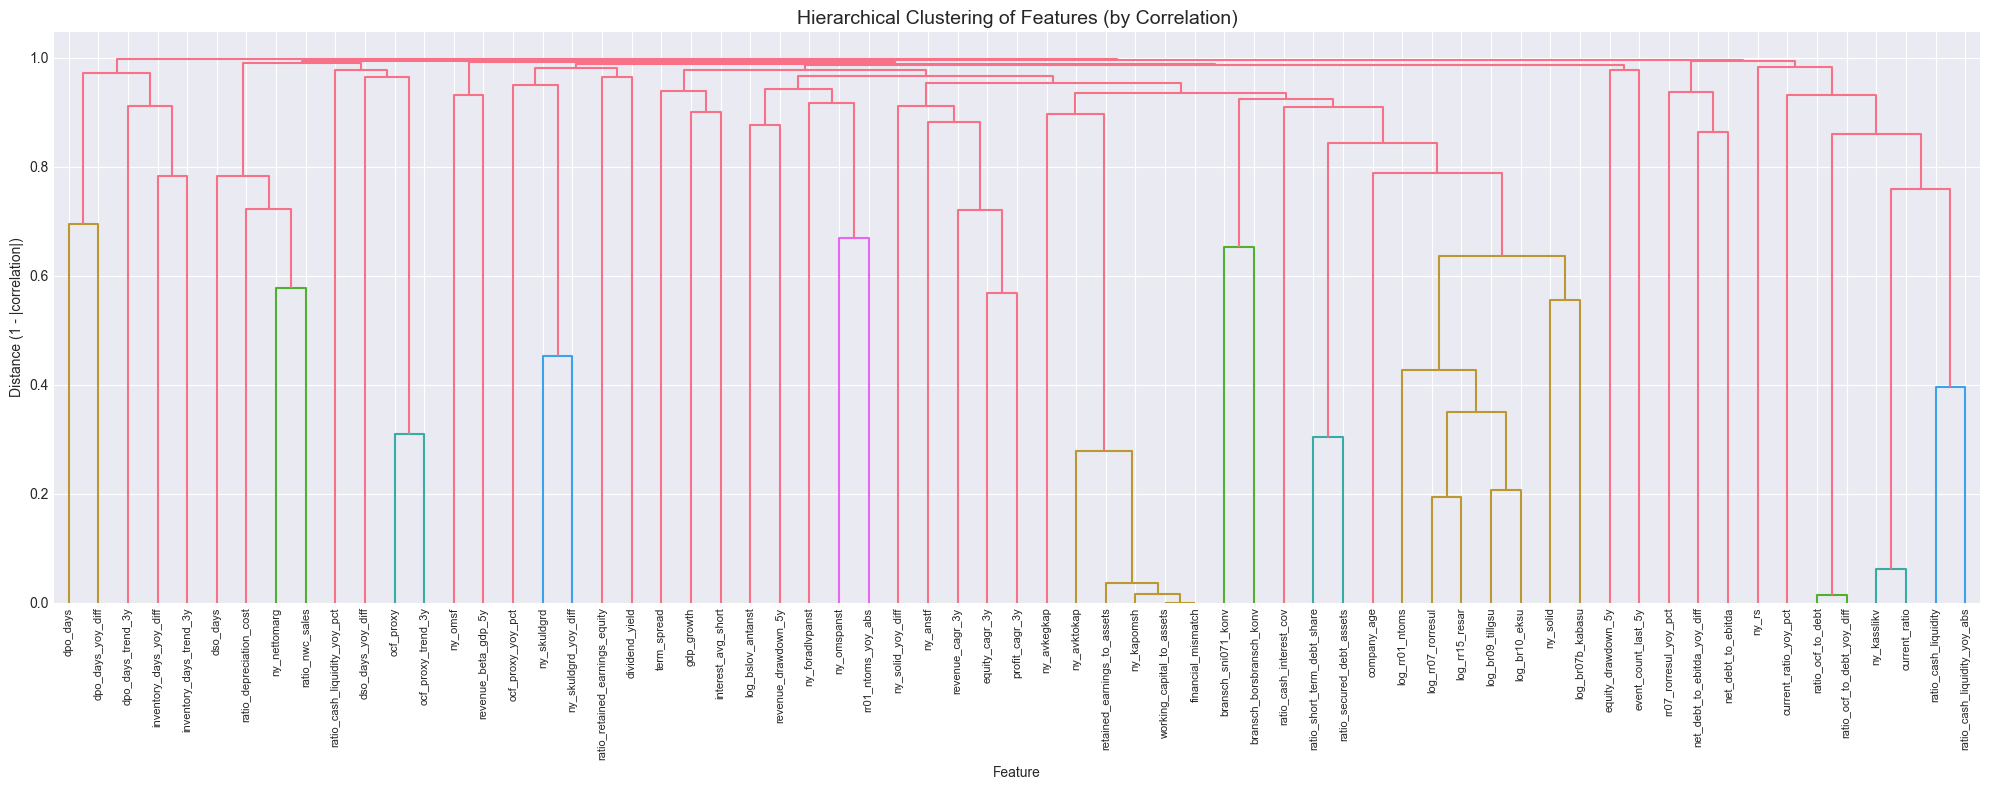


HIGH CORRELATION PAIRS (|r| > 0.85)
Found 8 feature pairs with correlation > 0.85

Top 15 pairs:
                   Feature1                    Feature2  Correlation
  working_capital_to_assets          financial_mismatch     1.000000
          ratio_ocf_to_debt  ratio_ocf_to_debt_yoy_diff     0.985539
                 ny_kapomsh   working_capital_to_assets     0.983968
                 ny_kapomsh          financial_mismatch     0.983968
  working_capital_to_assets retained_earnings_to_assets     0.969844
retained_earnings_to_assets          financial_mismatch     0.969844
                 ny_kapomsh retained_earnings_to_assets     0.950304
                ny_kasslikv               current_ratio     0.938789



In [13]:
# Compute global correlation matrix and hierarchical clustering
print("Computing global correlation matrix across all features...")
corr_matrix = baseline_X_train.corr().abs()

# Hierarchical clustering of features
print("Performing hierarchical clustering of features...")
corr_condensed = squareform(1 - corr_matrix)
linkage_matrix = linkage(corr_condensed, method='average')

# Visualize dendrogram
plt.figure(figsize=(20, 8))
dendrogram(linkage_matrix, labels=baseline_X_train.columns, leaf_rotation=90, leaf_font_size=8)
plt.title('Hierarchical Clustering of Features (by Correlation)', fontsize=14)
plt.xlabel('Feature')
plt.ylabel('Distance (1 - |correlation|)')
plt.tight_layout()
plt.show()

# Identify highly correlated feature pairs (correlation > 0.85)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.85:
            high_corr_pairs.append({
                'Feature1': corr_matrix.columns[i],
                'Feature2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False)

print(f"\n{'='*60}")
print(f"HIGH CORRELATION PAIRS (|r| > 0.85)")
print(f"{'='*60}")
print(f"Found {len(high_corr_df)} feature pairs with correlation > 0.85")
if len(high_corr_df) > 0:
    print(f"\nTop 15 pairs:")
    print(high_corr_df.head(15).to_string(index=False))
print(f"{'='*60}\n")

In [14]:
# ========================================
# PHASE 3: STABILITY SELECTION
# ========================================

print(f"\n{'='*60}")
print(f"PHASE 3: STABILITY SELECTION (BOOTSTRAP)")
print(f"{'='*60}\n")

def stability_selection_bootstrap(X_df, y_series, n_iterations=100, sample_fraction=0.8, top_k=40):
    """
    Perform stability selection using bootstrap sampling.
    
    Parameters:
    -----------
    X_df : pd.DataFrame
        Feature matrix
    y_series : pd.Series
        Target variable
    n_iterations : int
        Number of bootstrap iterations
    sample_fraction : float
        Fraction of data to sample in each iteration
    top_k : int
        Number of top features to select in each iteration
    
    Returns:
    --------
    stability_scores : pd.Series
        Percentage of iterations each feature was selected
    """
    n_samples = len(X_df)
    sample_size = int(n_samples * sample_fraction)
    feature_selection_counts = {col: 0 for col in X_df.columns}
    
    print(f"Running {n_iterations} bootstrap iterations...")
    print(f"Sample size: {sample_size:,} ({sample_fraction*100:.0f}% of data)")
    print(f"Selecting top {top_k} features per iteration\n")
    
    for i in range(n_iterations):
        if (i+1) % 20 == 0:
            print(f"  Iteration {i+1}/{n_iterations}...")
        
        # Bootstrap sample with train/val split for early stopping
        sample_idx = np.random.choice(n_samples, sample_size, replace=True)
        X_sample = X_df.iloc[sample_idx]
        y_sample = y_series.iloc[sample_idx]
        
        # Split bootstrap sample into train/val for early stopping
        train_idx, val_idx = train_test_split(
            np.arange(len(X_sample)), 
            test_size=0.2, 
            stratify=y_sample, 
            random_state=42+i
        )
        X_train_boot = X_sample.iloc[train_idx]
        y_train_boot = y_sample.iloc[train_idx]
        X_val_boot = X_sample.iloc[val_idx]
        y_val_boot = y_sample.iloc[val_idx]
        
        # Train model with early stopping
        model = lgb.LGBMClassifier(**DEFAULT_PARAMS)
        model.fit(
            X_train_boot, y_train_boot,
            eval_set=[(X_val_boot, y_val_boot)],
            eval_metric='logloss',
            callbacks=[lgb.log_evaluation(0), lgb.early_stopping(50)]
        )
        
        # Get SHAP values on the full bootstrap sample
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_sample)
        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        
        # Select top-k features by SHAP importance
        feature_importance = pd.Series(mean_abs_shap, index=X_df.columns)
        top_features = feature_importance.nlargest(top_k).index
        
        # Increment selection counts
        for feat in top_features:
            feature_selection_counts[feat] += 1
    
    # Calculate stability scores (percentage of selections)
    stability_scores = pd.Series(feature_selection_counts) / n_iterations * 100
    return stability_scores.sort_values(ascending=False)

# Run stability selection on full feature set
stability_scores = stability_selection_bootstrap(
    baseline_X_train, 
    baseline_y_train, 
    n_iterations=100,
    sample_fraction=0.8,
    top_k=40
)

# Select features with stability >= 70%
stability_threshold = 70
stable_features = stability_scores[stability_scores >= stability_threshold].index.tolist()

print(f"\n{'='*60}")
print(f"STABILITY SELECTION SUMMARY")
print(f"{'='*60}")
print(f"Stability threshold: {stability_threshold}%")
print(f"Features selected: {len(stable_features)}")
print(f"\nTop 20 features by stability:")
print(stability_scores.head(20))
print(f"\nBottom 10 features by stability:")
print(stability_scores.tail(10))
print(f"{'='*60}\n")

# Store stability-selected features
STABILITY_SELECTED_FEATURES = stable_features


PHASE 3: STABILITY SELECTION (BOOTSTRAP)

Running 100 bootstrap iterations...
Sample size: 202,664 (80% of data)
Selecting top 40 features per iteration

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[776]	valid_0's binary_logloss: 0.0281158
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[634]	valid_0's binary_logloss: 0.0320268
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[669]	valid_0's binary_logloss: 0.029983
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[706]	valid_0's binary_logloss: 0.0272835
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[745]	valid_0's binary_logloss: 0.029478
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[678]	valid_0's binary_logloss: 0.0313922
Training until vali

In [16]:
# ========================================
# PHASE 4: BORUTA ALGORITHM
# ========================================

print(f"\n{'='*60}")
print(f"PHASE 4: BORUTA ALL-RELEVANT FEATURE SELECTION")
print(f"{'='*60}\n")

def boruta_selection(X_df, y_series, n_iterations=100, percentile=100, alpha=0.05):
    """
    Implement Boruta algorithm for all-relevant feature selection.
    
    Parameters:
    -----------
    X_df : pd.DataFrame
        Feature matrix
    y_series : pd.Series
        Target variable
    n_iterations : int
        Number of Boruta iterations
    percentile : int
        Percentile for shadow feature importance threshold
    alpha : float
        Statistical significance level
    
    Returns:
    --------
    confirmed_features : list
        Features confirmed as important
    rejected_features : list
        Features rejected as unimportant
    tentative_features : list
        Features that are borderline
    """
    from scipy.stats import binomtest
    
    print(f"Running Boruta with {n_iterations} iterations...")
    print(f"Shadow feature percentile: {percentile}")
    print(f"Statistical significance: {alpha}\n")
    
    n_features = X_df.shape[1]
    feature_hits = {col: 0 for col in X_df.columns}
    
    for i in range(n_iterations):
        if (i+1) % 20 == 0:
            print(f"  Iteration {i+1}/{n_iterations}...")
        
        # Create shadow features (random permutations)
        X_shadow = X_df.apply(np.random.permutation)
        X_shadow.columns = [f"shadow_{col}" for col in X_df.columns]
        
        # Combine original and shadow features
        X_combined = pd.concat([X_df, X_shadow], axis=1)
        
        # Split for early stopping
        train_idx, val_idx = train_test_split(
            np.arange(len(X_combined)), 
            test_size=0.2, 
            stratify=y_series, 
            random_state=42+i
        )
        X_train = X_combined.iloc[train_idx]
        y_train = y_series.iloc[train_idx]
        X_val = X_combined.iloc[val_idx]
        y_val = y_series.iloc[val_idx]
        
        # Train model with early stopping
        model = lgb.LGBMClassifier(**DEFAULT_PARAMS)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='logloss',
            callbacks=[lgb.log_evaluation(0), lgb.early_stopping(50)]
        )
        
        # Get feature importance (gain)
        importance_dict = dict(zip(X_combined.columns, model.feature_importances_))
        importance_df = pd.DataFrame({
            'feature': X_combined.columns,
            'importance': [importance_dict[col] for col in X_combined.columns]
        })
        
        # Calculate shadow threshold (max or percentile of shadow importance)
        shadow_importance = importance_df[importance_df['feature'].str.startswith('shadow_')]['importance']
        shadow_threshold = np.percentile(shadow_importance, percentile)
        
        # Count hits for original features
        original_importance = importance_df[~importance_df['feature'].str.startswith('shadow_')]
        for _, row in original_importance.iterrows():
            if row['importance'] > shadow_threshold:
                feature_hits[row['feature']] += 1
    
    # Statistical test: binomial test for each feature
    confirmed_features = []
    rejected_features = []
    tentative_features = []
    
    for feature, hits in feature_hits.items():
        # Binomial test: null hypothesis is random (50% probability)
        result_higher = binomtest(hits, n_iterations, 0.5, alternative='greater')
        result_lower = binomtest(hits, n_iterations, 0.5, alternative='less')
        
        if result_higher.pvalue < alpha:
            confirmed_features.append(feature)
        elif result_lower.pvalue < alpha:
            rejected_features.append(feature)
        else:
            tentative_features.append(feature)
    
    print(f"\n{'='*60}")
    print(f"BORUTA SELECTION SUMMARY")
    print(f"{'='*60}")
    print(f"Confirmed features: {len(confirmed_features)}")
    print(f"Rejected features:  {len(rejected_features)}")
    print(f"Tentative features: {len(tentative_features)}")
    print(f"{'='*60}\n")
    
    # Show hit distribution
    hit_distribution = pd.Series(feature_hits).sort_values(ascending=False)
    print(f"Top 20 features by Boruta hits:")
    print(hit_distribution.head(20))
    print(f"\nBottom 10 features by Boruta hits:")
    print(hit_distribution.tail(10))
    
    return confirmed_features, rejected_features, tentative_features, hit_distribution

# Run Boruta algorithm
boruta_confirmed, boruta_rejected, boruta_tentative, boruta_hits = boruta_selection(
    baseline_X_train, 
    baseline_y_train,
    n_iterations=100,
    percentile=100,
    alpha=0.05
)

# Store Boruta-selected features (confirmed + tentative)
BORUTA_SELECTED_FEATURES = boruta_confirmed + boruta_tentative

print(f"\nBoruta selected features (confirmed + tentative): {len(BORUTA_SELECTED_FEATURES)}")


PHASE 4: BORUTA ALL-RELEVANT FEATURE SELECTION

Running Boruta with 100 iterations...
Shadow feature percentile: 100
Statistical significance: 0.05

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[256]	valid_0's binary_logloss: 0.0441223
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[243]	valid_0's binary_logloss: 0.0472753
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[319]	valid_0's binary_logloss: 0.0445794
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[255]	valid_0's binary_logloss: 0.0473921
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 0.0467499
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[274]	valid_0's binary_logloss: 0.046664
Training until validati

In [18]:
# ========================================
# PHASE 5: SHAP INTERACTION ANALYSIS
# ========================================

print(f"\n{'='*60}")
print(f"PHASE 5: SHAP INTERACTION ANALYSIS")
print(f"{'='*60}\n")

# Calculate SHAP values for baseline model
print("Computing SHAP values for baseline model...")
explainer = shap.TreeExplainer(baseline_model)
shap_values = explainer.shap_values(baseline_X_train)

# Calculate mean absolute SHAP values (main effects)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.Series(mean_abs_shap, index=baseline_X_train.columns).sort_values(ascending=False)

print("✓ SHAP values computed\n")
print("Top 20 features by mean |SHAP|:")
print(shap_importance.head(20))

# Calculate SHAP interaction values (computationally expensive - use sample)
print("\nComputing SHAP interaction values on sample (5000 obs)...")
sample_size = min(5000, len(baseline_X_train))
sample_idx = np.random.choice(len(baseline_X_train), sample_size, replace=False)
X_sample = baseline_X_train.iloc[sample_idx]

shap_interaction_values = explainer.shap_interaction_values(X_sample)

# Calculate interaction strength for each feature pair
print("Analyzing feature interactions...")
n_features = baseline_X_train.shape[1]
interaction_matrix = np.zeros((n_features, n_features))

for i in range(n_features):
    for j in range(n_features):
        if i != j:
            # Mean absolute interaction effect
            interaction_matrix[i, j] = np.abs(shap_interaction_values[:, i, j]).mean()

interaction_df = pd.DataFrame(
    interaction_matrix, 
    index=baseline_X_train.columns, 
    columns=baseline_X_train.columns
)

# Show strongest interaction pairs (exploratory insight)
print("\n" + "="*60)
print("TOP FEATURE INTERACTION PAIRS")
print("="*60)
interaction_pairs = []
for i in range(n_features):
    for j in range(i+1, n_features):
        interaction_pairs.append({
            'Feature1': baseline_X_train.columns[i],
            'Feature2': baseline_X_train.columns[j],
            'Interaction': interaction_matrix[i, j],
            'Feature1_SHAP': shap_importance[baseline_X_train.columns[i]],
            'Feature2_SHAP': shap_importance[baseline_X_train.columns[j]]
        })

interaction_pairs_df = pd.DataFrame(interaction_pairs).sort_values('Interaction', ascending=False)
print("\nTop 15 feature pairs by interaction strength:")
print(interaction_pairs_df.head(15).to_string(index=False))
print("="*60)

# Identify features with high redundant interactions
# (high correlation + high interaction but low unique contribution)
redundant_interaction_features = []

for feat in baseline_X_train.columns:
    # Get features highly correlated with this feature
    high_corr_features = corr_matrix[feat][corr_matrix[feat] > 0.7].index.tolist()
    high_corr_features = [f for f in high_corr_features if f != feat]
    
    if len(high_corr_features) > 0:
        # Check if interaction strength is high
        max_interaction = interaction_df.loc[feat, high_corr_features].max()
        
        # Check if unique SHAP contribution is low
        unique_shap = shap_importance[feat]
        
        # Flag as redundant if:
        # 1. High interaction (> 0.01) AND low SHAP (below median), OR
        # 2. Interaction effect is large relative to main effect (interaction > 50% of SHAP)
        if max_interaction > 0.01 and (unique_shap < shap_importance.median() or max_interaction > unique_shap * 0.5):
            correlated_feat = high_corr_features[interaction_df.loc[feat, high_corr_features].argmax()]
            redundant_interaction_features.append({
                'Feature': feat,
                'SHAP_Importance': unique_shap,
                'Max_Interaction': max_interaction,
                'Interaction_Ratio': max_interaction / unique_shap if unique_shap > 0 else np.inf,
                'Correlated_With': correlated_feat
            })

# Create dataframe and handle empty case
redundant_df = pd.DataFrame(redundant_interaction_features)

if len(redundant_df) > 0:
    redundant_df = redundant_df.sort_values('SHAP_Importance')

print(f"\n{'='*60}")
print(f"SHAP INTERACTION REDUNDANCY ANALYSIS")
print(f"{'='*60}")
print(f"Features with redundant interactions: {len(redundant_df)}")
if len(redundant_df) > 0:
    print(f"\nPotentially redundant features:")
    print(redundant_df.to_string(index=False))
    print(f"\nNote: These features have high interaction with correlated features")
    print(f"but relatively low unique SHAP contribution.")
else:
    print("✓ No features flagged as having redundant interactions")
    print("  This suggests features are reasonably independent.")
print(f"{'='*60}\n")

# Select features by SHAP importance (top 40)
SHAP_SELECTED_FEATURES = shap_importance.nlargest(40).index.tolist()
print(f"SHAP-selected features (top 40): {len(SHAP_SELECTED_FEATURES)}")


PHASE 5: SHAP INTERACTION ANALYSIS

Computing SHAP values for baseline model...
✓ SHAP values computed

Top 20 features by mean |SHAP|:
dividend_yield                    0.498099
ratio_cash_liquidity              0.213139
ny_avkegkap                       0.202309
company_age                       0.194435
ny_solid                          0.190243
log_br07b_kabasu                  0.164377
ny_rs                             0.137763
ny_skuldgrd                       0.135365
revenue_cagr_3y                   0.117086
dpo_days_yoy_diff                 0.105808
rr01_ntoms_yoy_abs                0.097043
dso_days_yoy_diff                 0.096560
bransch_sni071_konv               0.095256
ratio_depreciation_cost           0.088187
ny_nettomarg                      0.086848
event_count_last_5y               0.084092
ratio_short_term_debt_share       0.078685
profit_cagr_3y                    0.077724
inventory_days_yoy_diff           0.076620
ratio_retained_earnings_equity    0.072259
dty


PHASE 6: COMPARING SELECTION METHODS

Feature selection comparison:
                       Feature  VIF_Selected  Stability_Selected  Boruta_Selected  SHAP_Selected  Stability_Score  Boruta_Hits  SHAP_Importance           VIF  Consensus_Score
          ratio_cash_liquidity          True                True             True           True            100.0           89         0.213139      2.104486                4
                   ny_avkegkap          True                True             True           True            100.0           96         0.202309      1.049823                4
                   company_age          True                True             True           True            100.0           49         0.194435      2.847726                4
                         ny_rs          True                True             True           True            100.0          100         0.137763      1.112342                4
               revenue_cagr_3y          True            

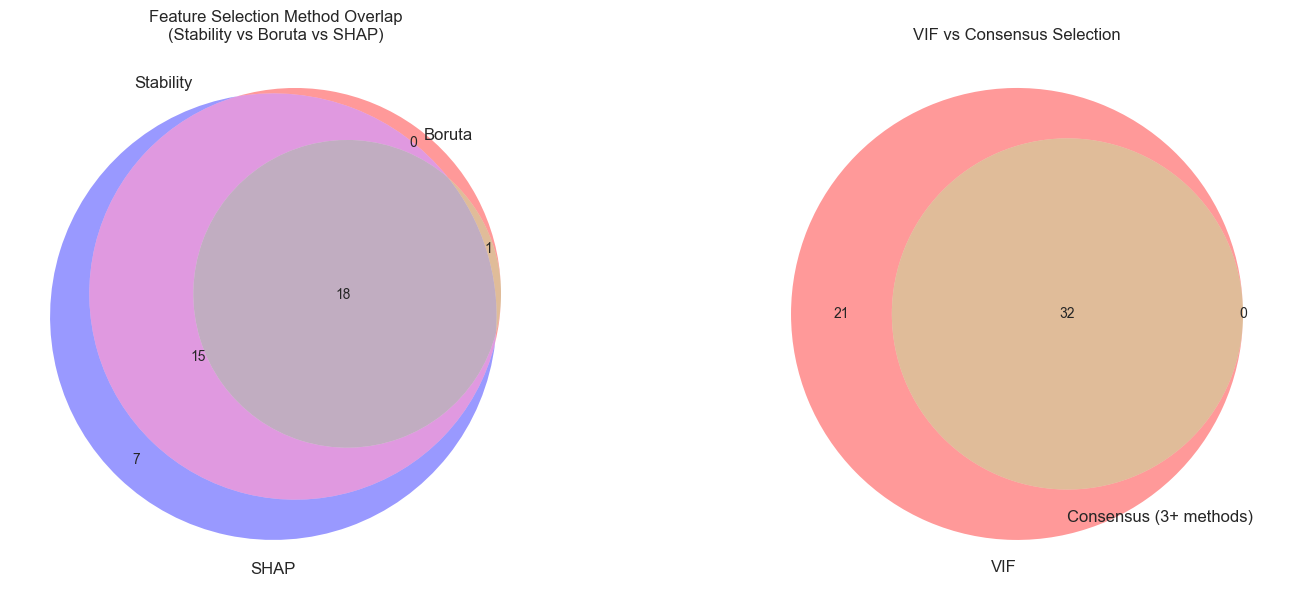


CONSENSUS ANALYSIS
Features selected by ALL 4 methods: 18
Features selected by ≥3 methods: 32

High-confidence features (all 4 methods):
                     Feature  SHAP_Importance  Stability_Score  Boruta_Hits
        ratio_cash_liquidity         0.213139            100.0           89
                 ny_avkegkap         0.202309            100.0           96
                 company_age         0.194435            100.0           49
                       ny_rs         0.137763            100.0          100
             revenue_cagr_3y         0.117086            100.0          100
           dpo_days_yoy_diff         0.105808            100.0          100
          rr01_ntoms_yoy_abs         0.097043             97.0           79
           dso_days_yoy_diff         0.096560            100.0          100
         bransch_sni071_konv         0.095256             99.0           81
         event_count_last_5y         0.084092            100.0          100
           ny_solid_yoy_di

In [19]:
# ========================================
# PHASE 6: METHOD COMPARISON & ENSEMBLE SELECTION
# ========================================

print(f"\n{'='*60}")
print(f"PHASE 6: COMPARING SELECTION METHODS")
print(f"{'='*60}\n")

# Create comprehensive comparison dataframe
all_features = baseline_X_train.columns.tolist()

comparison_df = pd.DataFrame({
    'Feature': all_features,
    'VIF_Selected': [f in VIF_SELECTED_FEATURES for f in all_features],
    'Stability_Selected': [f in STABILITY_SELECTED_FEATURES for f in all_features],
    'Boruta_Selected': [f in BORUTA_SELECTED_FEATURES for f in all_features],
    'SHAP_Selected': [f in SHAP_SELECTED_FEATURES for f in all_features],
})

# Add numeric metrics
comparison_df['Stability_Score'] = comparison_df['Feature'].map(stability_scores)
comparison_df['Boruta_Hits'] = comparison_df['Feature'].map(boruta_hits)
comparison_df['SHAP_Importance'] = comparison_df['Feature'].map(shap_importance)
comparison_df['VIF'] = comparison_df['Feature'].map(
    dict(zip(initial_vif['Feature'], initial_vif['VIF']))
)

# Calculate consensus score (number of methods selecting this feature)
comparison_df['Consensus_Score'] = (
    comparison_df['VIF_Selected'].astype(int) +
    comparison_df['Stability_Selected'].astype(int) +
    comparison_df['Boruta_Selected'].astype(int) +
    comparison_df['SHAP_Selected'].astype(int)
)

# Sort by consensus score and SHAP importance
comparison_df = comparison_df.sort_values(['Consensus_Score', 'SHAP_Importance'], ascending=[False, False])

print("Feature selection comparison:")
print(comparison_df.to_string(index=False))

# Venn diagram analysis
from matplotlib_venn import venn3, venn2
import matplotlib.pyplot as plt

# Create Venn diagram for 3 main methods (excluding VIF as it's a preprocessing step)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Venn 1: Stability vs Boruta vs SHAP
set_stability = set(STABILITY_SELECTED_FEATURES)
set_boruta = set(BORUTA_SELECTED_FEATURES)
set_shap = set(SHAP_SELECTED_FEATURES)

venn3([set_stability, set_boruta, set_shap], 
      set_labels=('Stability', 'Boruta', 'SHAP'),
      ax=axes[0])
axes[0].set_title('Feature Selection Method Overlap\n(Stability vs Boruta vs SHAP)', fontsize=12)

# Venn 2: VIF vs Consensus (3+ methods)
set_vif = set(VIF_SELECTED_FEATURES)
consensus_features = comparison_df[comparison_df['Consensus_Score'] >= 3]['Feature'].tolist()
set_consensus = set(consensus_features)

venn2([set_vif, set_consensus], 
      set_labels=('VIF', 'Consensus (3+ methods)'),
      ax=axes[1])
axes[1].set_title('VIF vs Consensus Selection', fontsize=12)

plt.tight_layout()
plt.show()

# Consensus features (selected by 3+ methods)
consensus_3plus = comparison_df[comparison_df['Consensus_Score'] >= 3]
consensus_4 = comparison_df[comparison_df['Consensus_Score'] == 4]

print(f"\n{'='*60}")
print(f"CONSENSUS ANALYSIS")
print(f"{'='*60}")
print(f"Features selected by ALL 4 methods: {len(consensus_4)}")
print(f"Features selected by ≥3 methods: {len(consensus_3plus)}")
print(f"\nHigh-confidence features (all 4 methods):")
print(consensus_4[['Feature', 'SHAP_Importance', 'Stability_Score', 'Boruta_Hits']].to_string(index=False))
print(f"{'='*60}\n")

# Create ensemble feature set
# Strategy: Include all consensus (3+) features, then add top disputed features by SHAP
CONSENSUS_FEATURES = consensus_3plus['Feature'].tolist()

print(f"Consensus features (3+ methods): {len(CONSENSUS_FEATURES)}")
print(f"Target range: 30-40 features\n")

In [20]:
# ========================================
# PHASE 7: FINAL PRUNING WITH RFECV
# ========================================

print(f"\n{'='*60}")
print(f"PHASE 7: RECURSIVE FEATURE ELIMINATION (RFECV)")
print(f"{'='*60}\n")

# Custom LightGBM estimator for RFECV
from sklearn.base import BaseEstimator, ClassifierMixin

class LGBMEstimator(BaseEstimator, ClassifierMixin):
    """LightGBM wrapper for sklearn compatibility with early stopping."""
    
    def __init__(self, params=None):
        self.params = params or DEFAULT_PARAMS
        self.model = None
        self.feature_importances_ = None
    
    def fit(self, X, y):
        # Split for early stopping
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )
        
        self.model = lgb.LGBMClassifier(**self.params)
        self.model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='logloss',
            callbacks=[lgb.log_evaluation(0), lgb.early_stopping(50)]
        )
        self.feature_importances_ = self.model.feature_importances_
        return self
    
    def predict_proba(self, X):
        if self.model is None:
            raise ValueError("Model not fitted yet")
        return self.model.predict_proba(X)
    
    def predict(self, X):
        return self.model.predict(X)

# Prepare data for RFECV using consensus features
X_consensus = baseline_X_train[CONSENSUS_FEATURES]
y_consensus = baseline_y_train

print(f"Starting with {len(CONSENSUS_FEATURES)} consensus features")
print(f"Target: Find optimal feature count in 30-40 range\n")

# Test different feature counts
test_feature_counts = [30, 35, 40, len(CONSENSUS_FEATURES)]
rfecv_results = []

for n_features in test_feature_counts:
    if n_features > len(CONSENSUS_FEATURES):
        continue
    
    print(f"Testing with {n_features} features...")
    
    # Use stratified 3-fold CV for speed
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # Manual RFE since RFECV might be slow
    current_features = CONSENSUS_FEATURES.copy()
    feature_ranking = []
    
    while len(current_features) > n_features:
        # Train model on current features
        X_current = baseline_X_train[current_features]
        estimator = LGBMEstimator()
        estimator.fit(X_current, baseline_y_train)
        
        # Get feature importances
        importances = pd.Series(
            estimator.feature_importances_,
            index=current_features
        ).sort_values()
        
        # Remove least important feature
        least_important = importances.index[0]
        current_features.remove(least_important)
        feature_ranking.append(least_important)
    
    # Evaluate with CV
    cv_scores = []
    for train_idx, val_idx in cv.split(baseline_X_train, baseline_y_train):
        X_train_cv = baseline_X_train.iloc[train_idx][current_features]
        y_train_cv = baseline_y_train.iloc[train_idx]
        X_val_cv = baseline_X_train.iloc[val_idx][current_features]
        y_val_cv = baseline_y_train.iloc[val_idx]
        
        estimator = LGBMEstimator()
        estimator.fit(X_train_cv, y_train_cv)
        y_pred_proba = estimator.predict_proba(X_val_cv)[:, 1]
        
        pr_auc = average_precision_score(y_val_cv, y_pred_proba)
        cv_scores.append(pr_auc)
    
    mean_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)
    
    rfecv_results.append({
        'n_features': n_features,
        'selected_features': current_features,
        'mean_pr_auc': mean_score,
        'std_pr_auc': std_score
    })
    
    print(f"  → PR-AUC: {mean_score:.4f} ± {std_score:.4f}")

# Select optimal feature count
rfecv_df = pd.DataFrame(rfecv_results).sort_values('mean_pr_auc', ascending=False)

print(f"\n{'='*60}")
print(f"RFECV RESULTS")
print(f"{'='*60}")
print(rfecv_df[['n_features', 'mean_pr_auc', 'std_pr_auc']].to_string(index=False))
print(f"{'='*60}\n")

# Select best performing feature set
optimal_result = rfecv_df.iloc[0]
FINAL_SELECTED_FEATURES = optimal_result['selected_features']
optimal_n_features = optimal_result['n_features']

print(f"Optimal feature count: {optimal_n_features}")
print(f"Expected PR-AUC: {optimal_result['mean_pr_auc']:.4f} ± {optimal_result['std_pr_auc']:.4f}")
print(f"\nFinal selected features:")
for i, feat in enumerate(FINAL_SELECTED_FEATURES, 1):
    print(f"  {i:2d}. {feat}")


PHASE 7: RECURSIVE FEATURE ELIMINATION (RFECV)

Starting with 32 consensus features
Target: Find optimal feature count in 30-40 range

Testing with 30 features...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.0437867
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[253]	valid_0's binary_logloss: 0.043621
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[189]	valid_0's binary_logloss: 0.0492805
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[195]	valid_0's binary_logloss: 0.0488464
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[238]	valid_0's binary_logloss: 0.0454402
  → PR-AUC: 0.6384 ± 0.0084
Testing with 32 features...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration


PHASE 8: INTERPRETABILITY & MONOTONICITY CHECKS

Training final model on 32 selected features...
[50]	training's binary_logloss: 0.0452582	valid_1's binary_logloss: 0.0495259
[100]	training's binary_logloss: 0.0392184	valid_1's binary_logloss: 0.0472536
[150]	training's binary_logloss: 0.0352534	valid_1's binary_logloss: 0.0468509
[200]	training's binary_logloss: 0.0323714	valid_1's binary_logloss: 0.0466775
[250]	training's binary_logloss: 0.0300898	valid_1's binary_logloss: 0.0466251

FINAL MODEL PERFORMANCE
Features: 32
ROC-AUC:  0.9497 (baseline: 0.9527)
PR-AUC:   0.6409 (baseline: 0.6487)
Δ ROC-AUC: -0.0030
Δ PR-AUC:  -0.0079

Computing SHAP values for interpretability analysis...


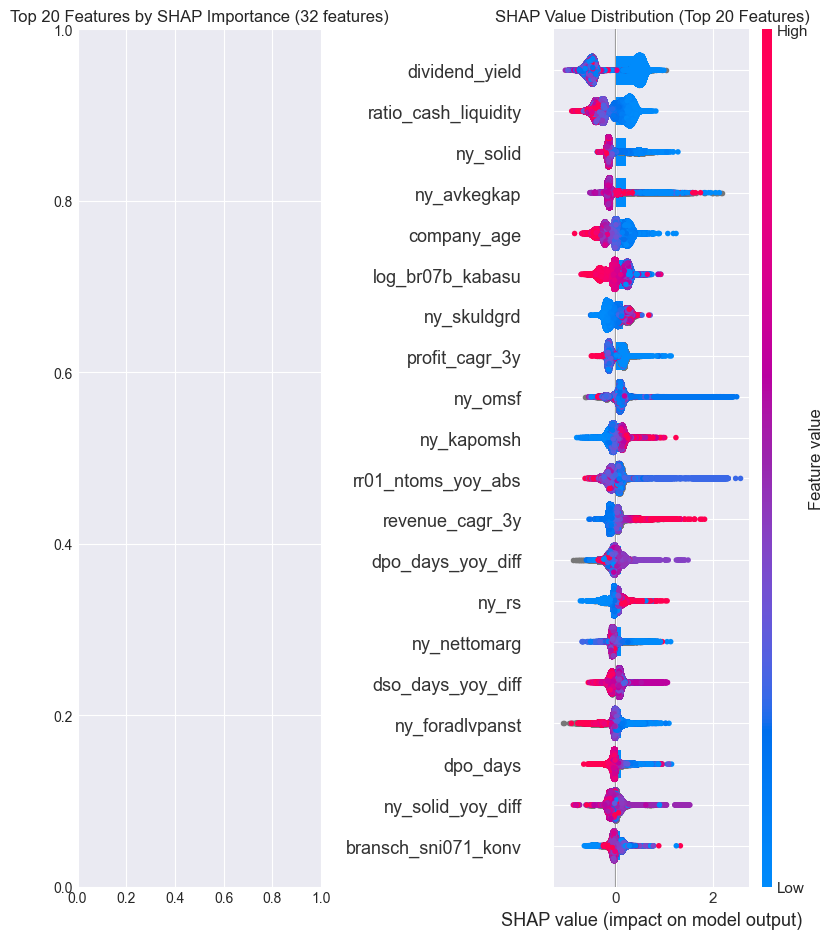


FEATURE GROUP DIVERSITY
TRENDS              :  9 features ( 28.1%)
DERIVED_RATIOS      :  7 features ( 21.9%)
WORKING_CAPITAL     :  5 features ( 15.6%)
BALANCE_SHEET       :  3 features (  9.4%)
TEMPORAL            :  3 features (  9.4%)
OPERATIONAL         :  3 features (  9.4%)
INCOME_STATEMENT    :  2 features (  6.2%)
CRISIS_HISTORY      :  1 features (  3.1%)

Checking for counter-intuitive relationships...
✓ No concerning non-monotonic relationships detected




In [22]:
# ========================================
# PHASE 8: XAI INTERPRETABILITY CHECKS
# ========================================

print(f"\n{'='*60}")
print(f"PHASE 8: INTERPRETABILITY & MONOTONICITY CHECKS")
print(f"{'='*60}\n")

# Train final model on selected features
print(f"Training final model on {len(FINAL_SELECTED_FEATURES)} selected features...")
X_final = X[FINAL_SELECTED_FEATURES]

final_model_results = run_lightgbm_training(
    X=X_final,
    y=y,
    dataset_description=f"Final Model - {len(FINAL_SELECTED_FEATURES)} Features",
    use_wandb=False,
)

final_model = final_model_results["model"]
X_final_train = final_model_results["X_train"]
X_final_val = final_model_results["X_val"]
y_final_train = final_model_results["y_train"]
y_final_val = final_model_results["y_val"]
y_final_pred_proba = final_model_results["y_val_proba"]

final_pr_auc = average_precision_score(y_final_val, y_final_pred_proba)
final_roc_auc = roc_auc_score(y_final_val, y_final_pred_proba)

print(f"\n{'='*60}")
print(f"FINAL MODEL PERFORMANCE")
print(f"{'='*60}")
print(f"Features: {len(FINAL_SELECTED_FEATURES)}")
print(f"ROC-AUC:  {final_roc_auc:.4f} (baseline: {baseline_auc:.4f})")
print(f"PR-AUC:   {final_pr_auc:.4f} (baseline: {baseline_pr_auc:.4f})")
print(f"Δ ROC-AUC: {final_roc_auc - baseline_auc:+.4f}")
print(f"Δ PR-AUC:  {final_pr_auc - baseline_pr_auc:+.4f}")
print(f"{'='*60}\n")

# Compute SHAP values for final model
print("Computing SHAP values for interpretability analysis...")
final_explainer = shap.TreeExplainer(final_model)
final_shap_values = final_explainer.shap_values(X_final_train)

# SHAP summary plot (bar)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

shap.summary_plot(final_shap_values, X_final_train, plot_type="bar", show=False, max_display=20)
axes[0].set_title(f"Top 20 Features by SHAP Importance ({len(FINAL_SELECTED_FEATURES)} features)", fontsize=12)

# SHAP summary plot (beeswarm)
shap.summary_plot(final_shap_values, X_final_train, show=False, max_display=20)
axes[1].set_title("SHAP Value Distribution (Top 20 Features)", fontsize=12)

plt.tight_layout()
plt.show()

# Check feature group diversity
from credit_risk_xai.config import FEATURE_GROUPS_BY_SOURCE

feature_group_counts = {}
for group_name, group_features in FEATURE_GROUPS_BY_SOURCE.items():
    count = len([f for f in FINAL_SELECTED_FEATURES if f in group_features])
    if count > 0:
        feature_group_counts[group_name] = count

print(f"\n{'='*60}")
print(f"FEATURE GROUP DIVERSITY")
print(f"{'='*60}")
for group, count in sorted(feature_group_counts.items(), key=lambda x: x[1], reverse=True):
    pct = count / len(FINAL_SELECTED_FEATURES) * 100
    print(f"{group:20s}: {count:2d} features ({pct:5.1f}%)")
print(f"{'='*60}\n")

# Flag potentially problematic features for manual review
print("Checking for counter-intuitive relationships...")
counter_intuitive_flags = []

# Calculate correlation with target for each feature
target_correlations = X_final_train.corrwith(y_final_train)

for feat in FINAL_SELECTED_FEATURES[:20]:  # Check top 20
    # Get SHAP dependence
    feat_idx = list(X_final_train.columns).index(feat)
    shap_values_feat = final_shap_values[:, feat_idx]
    feature_values = X_final_train[feat].values
    
    # Check for monotonicity using correlation
    shap_feature_corr = np.corrcoef(feature_values, shap_values_feat)[0, 1]
    
    # Flag if SHAP relationship is weak or counter to expected
    if abs(shap_feature_corr) < 0.3:
        counter_intuitive_flags.append({
            'Feature': feat,
            'SHAP_Feature_Corr': shap_feature_corr,
            'Target_Corr': target_correlations[feat],
            'Flag': 'Non-monotonic relationship'
        })

if len(counter_intuitive_flags) > 0:
    flags_df = pd.DataFrame(counter_intuitive_flags)
    print(f"\n⚠ Features flagged for manual review ({len(flags_df)}):")
    print(flags_df.to_string(index=False))
else:
    print("✓ No concerning non-monotonic relationships detected")

print(f"\n{'='*60}\n")


PHASE 8.5: TRAIN MODELS FOR EACH SELECTION METHOD

Training model: Baseline (All) (65 features)...
  → ROC-AUC: 0.9527 | PR-AUC: 0.6487 | Brier: 0.0105 | LogLoss: 0.0459

Training model: VIF (53 features)...
[50]	training's binary_logloss: 0.0449009	valid_1's binary_logloss: 0.0494828
[100]	training's binary_logloss: 0.0385091	valid_1's binary_logloss: 0.047034
[150]	training's binary_logloss: 0.0342634	valid_1's binary_logloss: 0.0464022
[200]	training's binary_logloss: 0.0310829	valid_1's binary_logloss: 0.0462455
[250]	training's binary_logloss: 0.0286506	valid_1's binary_logloss: 0.0461823
[300]	training's binary_logloss: 0.026461	valid_1's binary_logloss: 0.0460688
[350]	training's binary_logloss: 0.0246063	valid_1's binary_logloss: 0.0461029
  → ROC-AUC: 0.9516 | PR-AUC: 0.6481 | Brier: 0.0104 | LogLoss: 0.0460

Training model: Stability (34 features)...
[50]	training's binary_logloss: 0.045329	valid_1's binary_logloss: 0.0494823
[100]	training's binary_logloss: 0.0391793	valid_

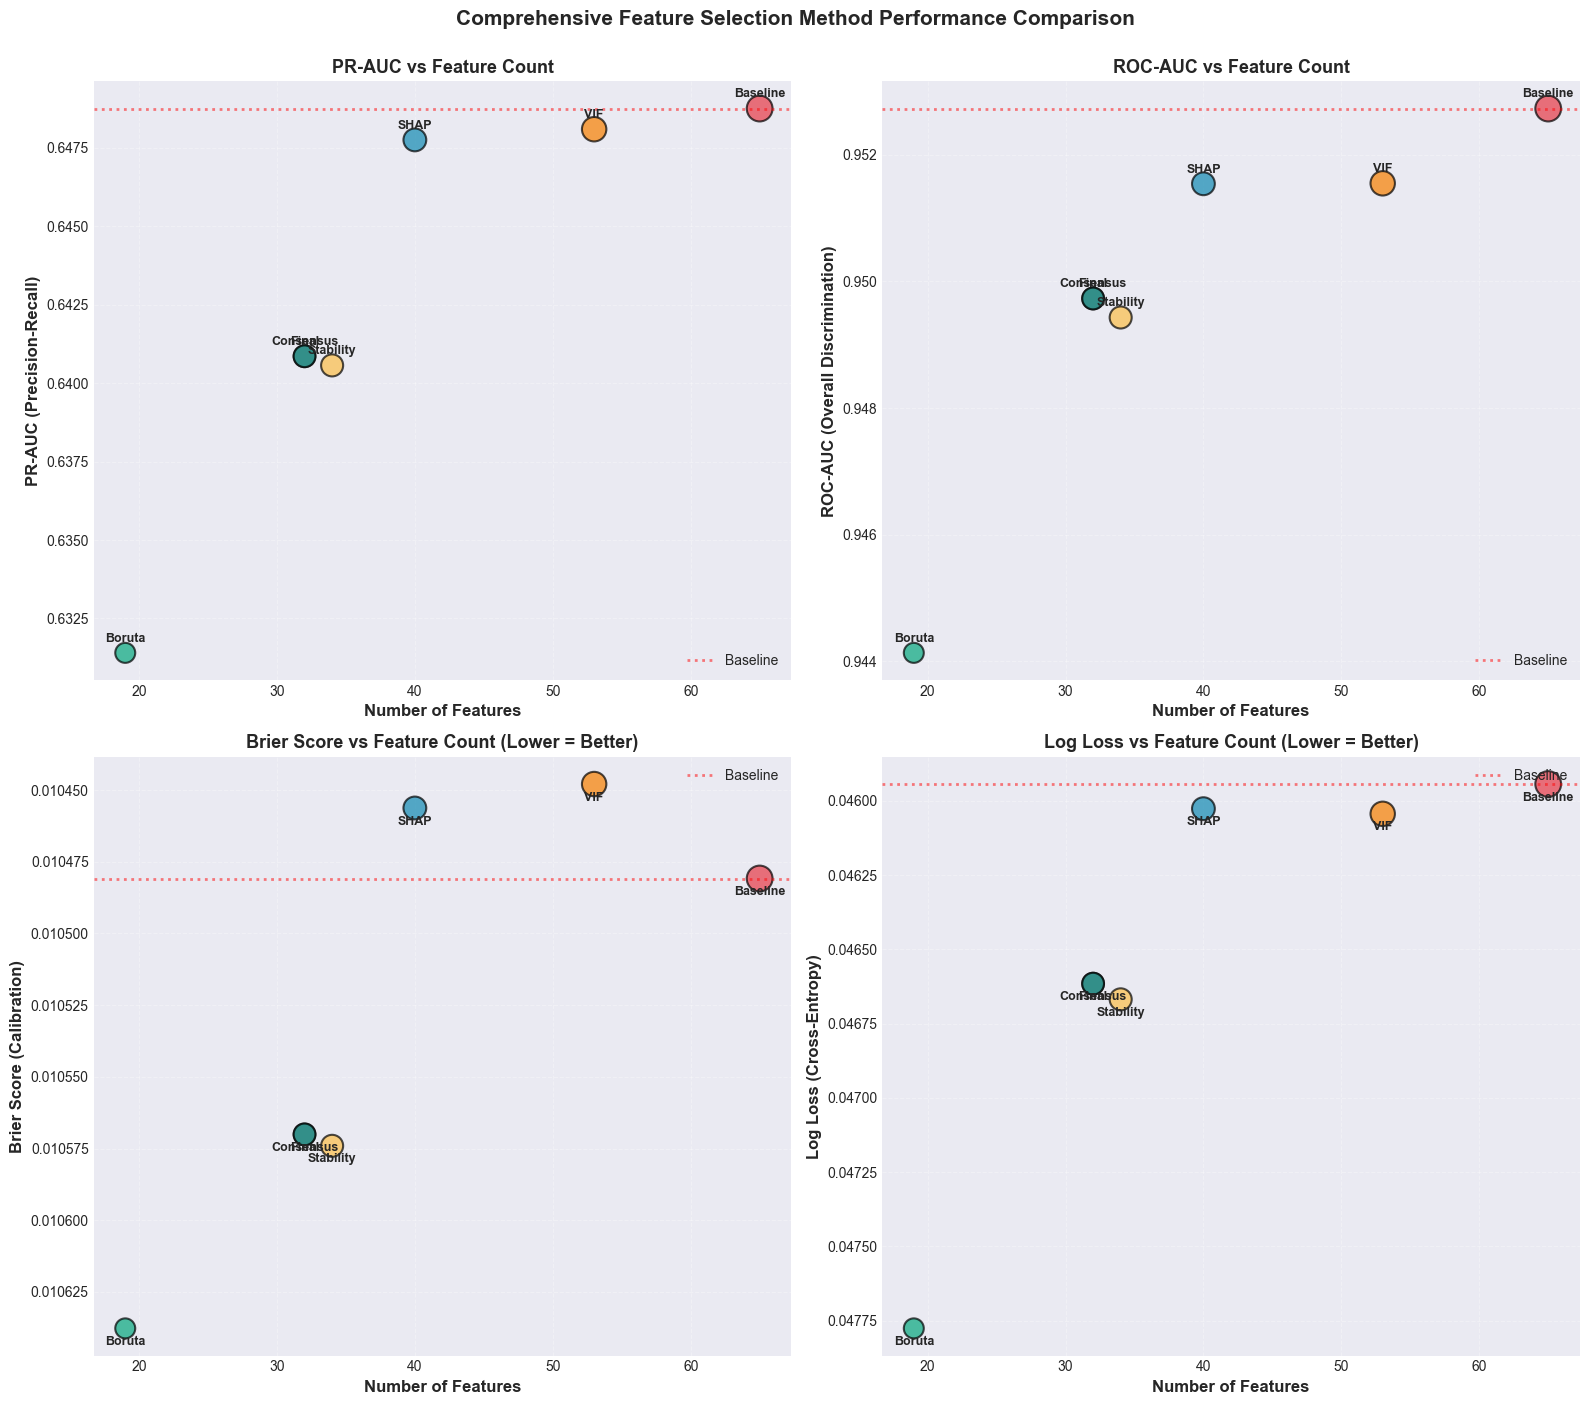


KEY INSIGHTS FROM METHOD COMPARISON
Best PR-AUC:     Baseline (All)       (65 features) = 0.6487
Best ROC-AUC:    Baseline (All)       (65 features) = 0.9527
Best Brier:      VIF                  (53 features) = 0.0104
Best Log Loss:   Baseline (All)       (65 features) = 0.0459




In [25]:
# ========================================
# PHASE 8.5: COMPREHENSIVE METHOD PERFORMANCE COMPARISON
# ========================================

print(f"\n{'='*60}")
print(f"PHASE 8.5: TRAIN MODELS FOR EACH SELECTION METHOD")
print(f"{'='*60}\n")

from sklearn.metrics import brier_score_loss, log_loss

# Define all feature sets to compare
feature_sets = {
    'Baseline (All)': ORIGINAL_FEATURES,
    'VIF': VIF_SELECTED_FEATURES,
    'Stability': STABILITY_SELECTED_FEATURES,
    'Boruta': BORUTA_SELECTED_FEATURES,
    'SHAP': SHAP_SELECTED_FEATURES,
    'Consensus (3+)': CONSENSUS_FEATURES,
    'Final (RFECV)': FINAL_SELECTED_FEATURES
}

# Train models and collect metrics
method_performance = []

for method_name, features in feature_sets.items():
    print(f"Training model: {method_name} ({len(features)} features)...")
    
    # Use existing results for baseline and final
    if method_name == 'Baseline (All)':
        y_pred_proba = baseline_y_pred_proba
        y_true = baseline_y_val
    elif method_name == 'Final (RFECV)':
        y_pred_proba = y_final_pred_proba
        y_true = y_final_val
    else:
        # Train new model on this feature set
        X_method = X[features]
        method_results = run_lightgbm_training(
            X=X_method,
            y=y,
            dataset_description=f"{method_name} - {len(features)} Features",
            use_wandb=False,
        )
        y_pred_proba = method_results["y_val_proba"]
        y_true = method_results["y_val"]
    
    # Calculate all metrics
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    pr_auc = average_precision_score(y_true, y_pred_proba)
    brier = brier_score_loss(y_true, y_pred_proba)
    logloss = log_loss(y_true, y_pred_proba)
    
    method_performance.append({
        'Method': method_name,
        'N_Features': len(features),
        'ROC_AUC': roc_auc,
        'PR_AUC': pr_auc,
        'Brier_Score': brier,
        'Log_Loss': logloss
    })
    
    print(f"  → ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f} | Brier: {brier:.4f} | LogLoss: {logloss:.4f}\n")

# Create performance dataframe
performance_df = pd.DataFrame(method_performance)

print(f"\n{'='*80}")
print(f"COMPREHENSIVE PERFORMANCE COMPARISON ACROSS ALL METHODS")
print(f"{'='*80}")
print(performance_df.to_string(index=False))
print(f"{'='*80}\n")

# Export performance comparison
perf_output_path = PROJ_ROOT / "notebooks" / "method_performance_comparison.csv"
performance_df.to_csv(perf_output_path, index=False)
print(f"✓ Performance comparison exported to: {perf_output_path}\n")

# ========================================
# VISUALIZATION: 4-METRIC SCATTER PLOTS
# ========================================

print("Creating comprehensive 4-metric scatter plots...")

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Define color mapping for methods
method_colors = {
    'Baseline (All)': '#E63946',      # Red
    'VIF': '#F77F00',                  # Orange
    'Stability': '#FCBF49',            # Yellow
    'Boruta': '#06A77D',               # Teal
    'SHAP': '#118AB2',                 # Blue
    'Consensus (3+)': '#073B4C',       # Dark blue
    'Final (RFECV)': '#2A9D8F'         # Green
}

# Get colors for each method
colors = [method_colors[m] for m in performance_df['Method']]
sizes = [150 + (n_feat * 3) for n_feat in performance_df['N_Features']]  # Size scales with feature count

# Plot 1: PR-AUC vs Feature Count
ax1 = axes[0, 0]
scatter1 = ax1.scatter(performance_df['N_Features'], performance_df['PR_AUC'], 
                       c=colors, s=sizes, alpha=0.7, edgecolors='black', linewidth=1.5)
for idx, row in performance_df.iterrows():
    method_short = row['Method'].replace(' (All)', '').replace(' (3+)', '').replace(' (RFECV)', '')
    ax1.annotate(method_short, 
                (row['N_Features'], row['PR_AUC']),
                textcoords="offset points", 
                xytext=(0, 8), 
                ha='center', 
                fontsize=9,
                fontweight='bold')
ax1.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
ax1.set_ylabel('PR-AUC (Precision-Recall)', fontsize=12, fontweight='bold')
ax1.set_title('PR-AUC vs Feature Count', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.axhline(baseline_pr_auc, color='red', linestyle=':', alpha=0.5, linewidth=2, label='Baseline')
ax1.legend(loc='lower right')

# Plot 2: ROC-AUC vs Feature Count
ax2 = axes[0, 1]
scatter2 = ax2.scatter(performance_df['N_Features'], performance_df['ROC_AUC'], 
                       c=colors, s=sizes, alpha=0.7, edgecolors='black', linewidth=1.5)
for idx, row in performance_df.iterrows():
    method_short = row['Method'].replace(' (All)', '').replace(' (3+)', '').replace(' (RFECV)', '')
    ax2.annotate(method_short, 
                (row['N_Features'], row['ROC_AUC']),
                textcoords="offset points", 
                xytext=(0, 8), 
                ha='center', 
                fontsize=9,
                fontweight='bold')
ax2.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
ax2.set_ylabel('ROC-AUC (Overall Discrimination)', fontsize=12, fontweight='bold')
ax2.set_title('ROC-AUC vs Feature Count', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.axhline(baseline_auc, color='red', linestyle=':', alpha=0.5, linewidth=2, label='Baseline')
ax2.legend(loc='lower right')

# Plot 3: Brier Score vs Feature Count (LOWER IS BETTER)
ax3 = axes[1, 0]
baseline_brier_comp = brier_score_loss(baseline_y_val, baseline_y_pred_proba)
scatter3 = ax3.scatter(performance_df['N_Features'], performance_df['Brier_Score'], 
                       c=colors, s=sizes, alpha=0.7, edgecolors='black', linewidth=1.5)
for idx, row in performance_df.iterrows():
    method_short = row['Method'].replace(' (All)', '').replace(' (3+)', '').replace(' (RFECV)', '')
    ax3.annotate(method_short, 
                (row['N_Features'], row['Brier_Score']),
                textcoords="offset points", 
                xytext=(0, -12), 
                ha='center', 
                fontsize=9,
                fontweight='bold')
ax3.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
ax3.set_ylabel('Brier Score (Calibration)', fontsize=12, fontweight='bold')
ax3.set_title('Brier Score vs Feature Count (Lower = Better)', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.axhline(baseline_brier_comp, color='red', linestyle=':', alpha=0.5, linewidth=2, label='Baseline')
ax3.legend(loc='upper right')
ax3.invert_yaxis()  # Invert so lower scores appear higher visually

# Plot 4: Log Loss vs Feature Count (LOWER IS BETTER)
ax4 = axes[1, 1]
baseline_logloss = log_loss(baseline_y_val, baseline_y_pred_proba)
scatter4 = ax4.scatter(performance_df['N_Features'], performance_df['Log_Loss'], 
                       c=colors, s=sizes, alpha=0.7, edgecolors='black', linewidth=1.5)
for idx, row in performance_df.iterrows():
    method_short = row['Method'].replace(' (All)', '').replace(' (3+)', '').replace(' (RFECV)', '')
    ax4.annotate(method_short, 
                (row['N_Features'], row['Log_Loss']),
                textcoords="offset points", 
                xytext=(0, -12), 
                ha='center', 
                fontsize=9,
                fontweight='bold')
ax4.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
ax4.set_ylabel('Log Loss (Cross-Entropy)', fontsize=12, fontweight='bold')
ax4.set_title('Log Loss vs Feature Count (Lower = Better)', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, linestyle='--')
ax4.axhline(baseline_logloss, color='red', linestyle=':', alpha=0.5, linewidth=2, label='Baseline')
ax4.legend(loc='upper right')
ax4.invert_yaxis()  # Invert so lower scores appear higher visually

plt.suptitle('Comprehensive Feature Selection Method Performance Comparison', 
             fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(PROJ_ROOT / "notebooks" / "method_performance_scatter.png", dpi=150, bbox_inches='tight')
print(f"✓ Scatter plot visualization saved to: {PROJ_ROOT / 'notebooks' / 'method_performance_scatter.png'}")
plt.show()

print(f"\n{'='*60}")
print(f"KEY INSIGHTS FROM METHOD COMPARISON")
print(f"{'='*60}")

# Find best methods for each metric
best_pr_auc = performance_df.loc[performance_df['PR_AUC'].idxmax()]
best_roc_auc = performance_df.loc[performance_df['ROC_AUC'].idxmax()]
best_brier = performance_df.loc[performance_df['Brier_Score'].idxmin()]  # Lower is better
best_logloss = performance_df.loc[performance_df['Log_Loss'].idxmin()]  # Lower is better

print(f"Best PR-AUC:     {best_pr_auc['Method']:20s} ({best_pr_auc['N_Features']:2.0f} features) = {best_pr_auc['PR_AUC']:.4f}")
print(f"Best ROC-AUC:    {best_roc_auc['Method']:20s} ({best_roc_auc['N_Features']:2.0f} features) = {best_roc_auc['ROC_AUC']:.4f}")
print(f"Best Brier:      {best_brier['Method']:20s} ({best_brier['N_Features']:2.0f} features) = {best_brier['Brier_Score']:.4f}")
print(f"Best Log Loss:   {best_logloss['Method']:20s} ({best_logloss['N_Features']:2.0f} features) = {best_logloss['Log_Loss']:.4f}")

print(f"\n{'='*60}\n")


PHASE 9: FINAL DOCUMENTATION & EXPORT

FINAL FEATURE SELECTION REPORT
 Final_Rank                        Feature    Feature_Group  Consensus_Score  Final_SHAP  SHAP_Importance  Stability_Score  Boruta_Hits       VIF  VIF_Selected  Stability_Selected  Boruta_Selected  SHAP_Selected
          1                 dividend_yield   DERIVED_RATIOS                3    0.504461         0.498099            100.0           14  1.036638          True                True            False           True
          2           ratio_cash_liquidity   DERIVED_RATIOS                4    0.265755         0.213139            100.0           89  2.104486          True                True             True           True
          3                       ny_solid    BALANCE_SHEET                3    0.210818         0.190243            100.0            0 14.055372          True                True            False           True
          4                    ny_avkegkap INCOME_STATEMENT                4    0

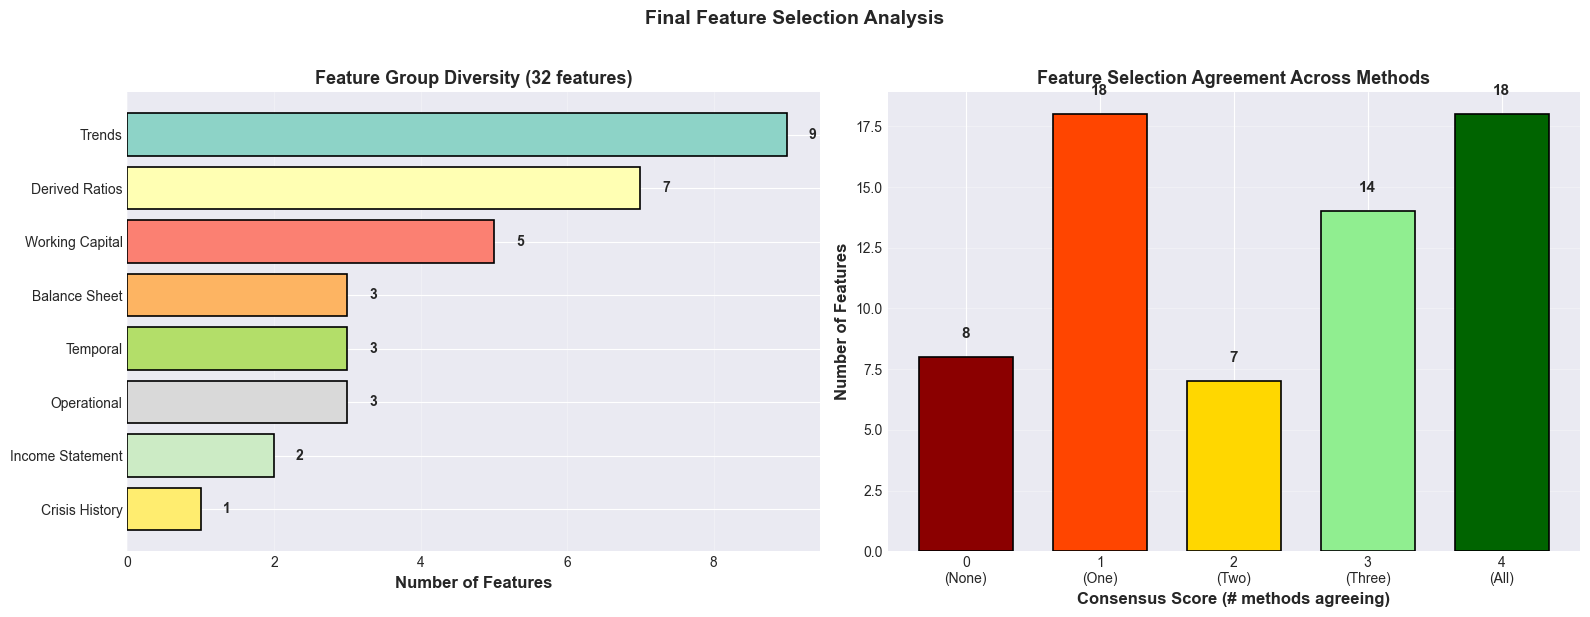


✓ FEATURE SELECTION PIPELINE COMPLETE!

Outputs generated:
  1. feature_selection_results.csv       - Final 32 selected features with all metrics
  2. feature_comparison_all.csv          - Full comparison across all 65 features
  3. method_performance_comparison.csv   - Performance metrics for each method
  4. method_performance_scatter.png      - 4-metric scatter plots
  5. feature_selection_summary.png       - Group diversity & consensus analysis



In [27]:
# ========================================
# PHASE 9: COMPREHENSIVE DOCUMENTATION & EXPORT
# ========================================

print(f"\n{'='*60}")
print(f"PHASE 9: FINAL DOCUMENTATION & EXPORT")
print(f"{'='*60}\n")

# Import brier_score_loss for final metrics
from sklearn.metrics import brier_score_loss

# ========================================
# CREATE FINAL FEATURE REPORT
# ========================================

# Create comprehensive feature report for selected features
final_report = comparison_df[comparison_df['Feature'].isin(FINAL_SELECTED_FEATURES)].copy()

# Add final SHAP importance from final model
final_shap_importance = pd.Series(
    np.abs(final_shap_values).mean(axis=0),
    index=X_final_train.columns
)
final_report['Final_SHAP'] = final_report['Feature'].map(final_shap_importance)

# Add feature group
def get_feature_group(feat):
    for group_name, group_features in FEATURE_GROUPS_BY_SOURCE.items():
        if feat in group_features:
            return group_name
    return "OTHER"

final_report['Feature_Group'] = final_report['Feature'].apply(get_feature_group)

# Add rank
final_report['Final_Rank'] = final_report['Final_SHAP'].rank(ascending=False, method='min').astype(int)

# Reorder columns for clarity
final_report = final_report[[
    'Final_Rank', 'Feature', 'Feature_Group', 
    'Consensus_Score', 'Final_SHAP', 'SHAP_Importance',
    'Stability_Score', 'Boruta_Hits', 'VIF',
    'VIF_Selected', 'Stability_Selected', 'Boruta_Selected', 'SHAP_Selected'
]].sort_values('Final_Rank')

print("FINAL FEATURE SELECTION REPORT")
print("="*120)
print(final_report.to_string(index=False))
print("="*120)

# ========================================
# EXPORT RESULTS
# ========================================

# Export selected features report
output_path = PROJ_ROOT / "notebooks" / "feature_selection_results.csv"
final_report.to_csv(output_path, index=False)
print(f"\n✓ Feature selection results exported to: {output_path}")

# Export full feature comparison (all 65 features)
full_comparison_path = PROJ_ROOT / "notebooks" / "feature_comparison_all.csv"
comparison_df.to_csv(full_comparison_path, index=False)
print(f"✓ Full feature comparison exported to: {full_comparison_path}")

# ========================================
# SUMMARY STATISTICS
# ========================================

# Calculate final metrics
baseline_brier = brier_score_loss(baseline_y_val, baseline_y_pred_proba)
final_brier = brier_score_loss(y_final_val, y_final_pred_proba)

print(f"\n{'='*80}")
print(f"FEATURE SELECTION PIPELINE SUMMARY")
print(f"{'='*80}")
print(f"\nFeature Count at Each Stage:")
print(f"  Original features:           {len(ORIGINAL_FEATURES):2d} (100.0%)")
print(f"  After VIF (threshold=10):    {len(VIF_SELECTED_FEATURES):2d} ({len(VIF_SELECTED_FEATURES)/len(ORIGINAL_FEATURES)*100:5.1f}%)")
print(f"  After Stability (≥70%):      {len(STABILITY_SELECTED_FEATURES):2d} ({len(STABILITY_SELECTED_FEATURES)/len(ORIGINAL_FEATURES)*100:5.1f}%)")
print(f"  After Boruta:                {len(BORUTA_SELECTED_FEATURES):2d} ({len(BORUTA_SELECTED_FEATURES)/len(ORIGINAL_FEATURES)*100:5.1f}%)")
print(f"  After SHAP (top 40):         {len(SHAP_SELECTED_FEATURES):2d} ({len(SHAP_SELECTED_FEATURES)/len(ORIGINAL_FEATURES)*100:5.1f}%)")
print(f"  Consensus (≥3 methods):      {len(CONSENSUS_FEATURES):2d} ({len(CONSENSUS_FEATURES)/len(ORIGINAL_FEATURES)*100:5.1f}%)")
print(f"  Final selected features:     {len(FINAL_SELECTED_FEATURES):2d} ({len(FINAL_SELECTED_FEATURES)/len(ORIGINAL_FEATURES)*100:5.1f}%)")

print(f"\nPerformance Metrics (Baseline vs Final):")
print(f"  Metric          Baseline    Final       Δ          ")
print(f"  {'-'*50}")
print(f"  PR-AUC          {baseline_pr_auc:.4f}      {final_pr_auc:.4f}      {final_pr_auc - baseline_pr_auc:+.4f}")
print(f"  ROC-AUC         {baseline_auc:.4f}      {final_roc_auc:.4f}      {final_roc_auc - baseline_auc:+.4f}")
print(f"  Brier Score     {baseline_brier:.4f}      {final_brier:.4f}      {final_brier - baseline_brier:+.4f}  (lower is better)")

print(f"\nFeature Group Diversity (Final {len(FINAL_SELECTED_FEATURES)} features):")
for group, count in sorted(feature_group_counts.items(), key=lambda x: x[1], reverse=True):
    pct = count / len(FINAL_SELECTED_FEATURES) * 100
    print(f"  {group:25s}: {count:2d} features ({pct:5.1f}%)")

print(f"{'='*80}\n")

# ========================================
# VISUALIZATION: FEATURE GROUP COMPOSITION
# ========================================

print("Creating feature group diversity visualization...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Feature group composition (horizontal bar)
ax1 = axes[0]
group_counts_sorted = sorted(feature_group_counts.items(), key=lambda x: x[1], reverse=True)
groups, counts = zip(*group_counts_sorted)
colors_groups = plt.cm.Set3(np.linspace(0, 1, len(groups)))
bars = ax1.barh(range(len(groups)), counts, color=colors_groups, edgecolor='black', linewidth=1.2)
ax1.set_yticks(range(len(groups)))
ax1.set_yticklabels([g.replace('_', ' ').title() for g in groups], fontsize=10)
ax1.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
ax1.set_title(f'Feature Group Diversity ({len(FINAL_SELECTED_FEATURES)} features)', fontsize=13, fontweight='bold')
ax1.grid(True, axis='x', alpha=0.3)
for i, v in enumerate(counts):
    ax1.text(v + 0.3, i, str(v), va='center', fontsize=10, fontweight='bold')
ax1.invert_yaxis()

# Plot 2: Method agreement (consensus score distribution)
ax2 = axes[1]
consensus_counts = comparison_df['Consensus_Score'].value_counts().sort_index()
colors_consensus = ['#8B0000', '#FF4500', '#FFD700', '#90EE90', '#006400']
bars = ax2.bar(consensus_counts.index, consensus_counts.values, 
               color=colors_consensus, edgecolor='black', linewidth=1.2, width=0.7)
ax2.set_xlabel('Consensus Score (# methods agreeing)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Features', fontsize=12, fontweight='bold')
ax2.set_title('Feature Selection Agreement Across Methods', fontsize=13, fontweight='bold')
ax2.set_xticks([0, 1, 2, 3, 4])
ax2.set_xticklabels(['0\n(None)', '1\n(One)', '2\n(Two)', '3\n(Three)', '4\n(All)'])
ax2.grid(True, axis='y', alpha=0.3)
for i, (idx, v) in enumerate(zip(consensus_counts.index, consensus_counts.values)):
    ax2.text(idx, v + 0.8, str(v), ha='center', fontsize=11, fontweight='bold')

plt.suptitle('Final Feature Selection Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(PROJ_ROOT / "notebooks" / "feature_selection_summary.png", dpi=150, bbox_inches='tight')
print(f"✓ Summary visualization saved to: {PROJ_ROOT / 'notebooks' / 'feature_selection_summary.png'}")
plt.show()

print(f"\n{'='*80}")
print(f"✓ FEATURE SELECTION PIPELINE COMPLETE!")
print(f"{'='*80}")
print(f"\nOutputs generated:")
print(f"  1. feature_selection_results.csv       - Final {len(FINAL_SELECTED_FEATURES)} selected features with all metrics")
print(f"  2. feature_comparison_all.csv          - Full comparison across all 65 features")
print(f"  3. method_performance_comparison.csv   - Performance metrics for each method")
print(f"  4. method_performance_scatter.png      - 4-metric scatter plots")
print(f"  5. feature_selection_summary.png       - Group diversity & consensus analysis")
print(f"{'='*80}\n")

In [28]:
# ========================================
# ALTERNATIVE FEATURE SELECTION STRATEGIES
# Testing less aggressive approaches
# ========================================

print(f"\n{'='*80}")
print(f"TESTING ALTERNATIVE FEATURE SELECTION STRATEGIES")
print(f"{'='*80}\n")

from scipy.stats import binomtest

# ========================================
# STRATEGY 1: SHAP Top-40 (Baseline comparison)
# ========================================

strategy_1_features = SHAP_SELECTED_FEATURES.copy()

print(f"STRATEGY 1: SHAP Top-40")
print(f"{'='*80}")
print(f"Description: Top 40 features by SHAP importance")
print(f"Features: {len(strategy_1_features)}")
print(f"Rationale: Maximally preserves predictive performance while reducing dimensionality")
print(f"{'='*80}\n")

# ========================================
# STRATEGY 2: Consensus >= 2 Methods (More Inclusive)
# ========================================

strategy_2_features = comparison_df[comparison_df['Consensus_Score'] >= 2]['Feature'].tolist()

print(f"STRATEGY 2: Consensus >= 2 Methods")
print(f"{'='*80}")
print(f"Description: Features selected by at least 2 out of 4 methods")
print(f"Features: {len(strategy_2_features)}")
print(f"Rationale: Balances multiple perspectives without requiring unanimous agreement")
print(f"{'='*80}")

# Show which methods selected these features
consensus_2_summary = comparison_df[comparison_df['Consensus_Score'] >= 2][
    ['Feature', 'VIF_Selected', 'Stability_Selected', 'Boruta_Selected', 'SHAP_Selected', 
     'Consensus_Score', 'SHAP_Importance']
].sort_values(['Consensus_Score', 'SHAP_Importance'], ascending=[False, False])

print(f"\nBreakdown by consensus score:")
for score in [4, 3, 2]:
    count = (comparison_df['Consensus_Score'] == score).sum()
    print(f"  {score} methods: {count:2d} features")

print(f"\nFeatures with consensus=2 (not in consensus=3):")
consensus_2_only = comparison_df[comparison_df['Consensus_Score'] == 2].sort_values('SHAP_Importance', ascending=False)
for idx, row in consensus_2_only.head(10).iterrows():
    methods = []
    if row['VIF_Selected']: methods.append('VIF')
    if row['Stability_Selected']: methods.append('Stab')
    if row['Boruta_Selected']: methods.append('Bor')
    if row['SHAP_Selected']: methods.append('SHAP')
    print(f"  {row['Feature']:30s} SHAP={row['SHAP_Importance']:.4f}  [{'+'.join(methods)}]")

print(f"{'='*80}\n")

# ========================================
# STRATEGY 3: Relaxed Boruta (α=0.1) + Consensus
# ========================================

print(f"STRATEGY 3: Relaxed Boruta (α=0.1) Simulation")
print(f"{'='*80}")
print(f"Description: Re-test Boruta with relaxed statistical threshold (α=0.10 vs 0.05)")
print(f"Note: Using existing hit data to simulate without re-running full algorithm\n")

# Simulate relaxed Boruta using existing hit counts
# With α=0.1, we need p-value < 0.1 instead of < 0.05
n_iterations = 100

boruta_relaxed_confirmed = []
boruta_relaxed_tentative = []
boruta_relaxed_rejected = []

for feature in comparison_df['Feature']:
    hits = comparison_df[comparison_df['Feature'] == feature]['Boruta_Hits'].values[0]
    
    # Binomial test: null hypothesis is random (50% probability)
    result_higher = binomtest(int(hits), n_iterations, 0.5, alternative='greater')
    result_lower = binomtest(int(hits), n_iterations, 0.5, alternative='less')
    
    if result_higher.pvalue < 0.10:  # Relaxed threshold
        boruta_relaxed_confirmed.append(feature)
    elif result_lower.pvalue < 0.10:
        boruta_relaxed_rejected.append(feature)
    else:
        boruta_relaxed_tentative.append(feature)

print(f"Original Boruta (α=0.05):")
print(f"  Confirmed: {len(boruta_confirmed):2d} features")
print(f"  Tentative: {len(boruta_tentative):2d} features")
print(f"  Rejected:  {len(boruta_rejected):2d} features")
print(f"  Total selected: {len(BORUTA_SELECTED_FEATURES)}")

print(f"\nRelaxed Boruta (α=0.10):")
print(f"  Confirmed: {len(boruta_relaxed_confirmed):2d} features")
print(f"  Tentative: {len(boruta_relaxed_tentative):2d} features")
print(f"  Rejected:  {len(boruta_relaxed_rejected):2d} features")
print(f"  Total selected: {len(boruta_relaxed_confirmed) + len(boruta_relaxed_tentative)}")

# Features gained by relaxing Boruta
boruta_relaxed_all = boruta_relaxed_confirmed + boruta_relaxed_tentative
new_boruta_features = [f for f in boruta_relaxed_all if f not in BORUTA_SELECTED_FEATURES]

print(f"\nFeatures GAINED by relaxing to α=0.1 ({len(new_boruta_features)} features):")
if len(new_boruta_features) > 0:
    for feat in sorted(new_boruta_features, 
                       key=lambda x: comparison_df[comparison_df['Feature']==x]['SHAP_Importance'].values[0], 
                       reverse=True)[:15]:
        shap_val = comparison_df[comparison_df['Feature']==feat]['SHAP_Importance'].values[0]
        hits = comparison_df[comparison_df['Feature']==feat]['Boruta_Hits'].values[0]
        print(f"  {feat:30s} SHAP={shap_val:.4f}  Boruta_Hits={hits:3.0f}")

# Now create Strategy 3: Use relaxed Boruta for new consensus
print(f"\nRecalculating consensus with Relaxed Boruta...")

# Update comparison_df with relaxed Boruta selections
comparison_df_relaxed = comparison_df.copy()
comparison_df_relaxed['Boruta_Relaxed_Selected'] = comparison_df_relaxed['Feature'].isin(boruta_relaxed_all)
comparison_df_relaxed['Consensus_Score_Relaxed'] = (
    comparison_df_relaxed['VIF_Selected'].astype(int) +
    comparison_df_relaxed['Stability_Selected'].astype(int) +
    comparison_df_relaxed['Boruta_Relaxed_Selected'].astype(int) +
    comparison_df_relaxed['SHAP_Selected'].astype(int)
)

strategy_3_features = comparison_df_relaxed[comparison_df_relaxed['Consensus_Score_Relaxed'] >= 3]['Feature'].tolist()

print(f"Original Consensus (≥3, α=0.05): {len(CONSENSUS_FEATURES)} features")
print(f"Relaxed Consensus (≥3, α=0.10):  {len(strategy_3_features)} features")
print(f"Difference: +{len(strategy_3_features) - len(CONSENSUS_FEATURES)} features")

print(f"{'='*80}\n")

# ========================================
# STRATEGY 4: Hybrid (Consensus Core + SHAP Top-Up)
# ========================================

print(f"STRATEGY 4: Hybrid (Consensus Core + SHAP Top-Up to 40)")
print(f"{'='*80}")
print(f"Description: Start with high-confidence consensus (≥3), top-up to 40 with SHAP")

# Start with consensus >= 3
strategy_4_core = CONSENSUS_FEATURES.copy()

# Add highest SHAP features not already in consensus until we reach 40
candidates = comparison_df[~comparison_df['Feature'].isin(strategy_4_core)].sort_values('SHAP_Importance', ascending=False)
strategy_4_topup = candidates.head(40 - len(strategy_4_core))['Feature'].tolist()
strategy_4_features = strategy_4_core + strategy_4_topup

print(f"Core (Consensus ≥3): {len(strategy_4_core)} features")
print(f"Top-up from SHAP:    {len(strategy_4_topup)} features")
print(f"Total:               {len(strategy_4_features)} features")

print(f"\nTop-up features (SHAP-based):")
for feat in strategy_4_topup[:10]:
    shap_val = comparison_df[comparison_df['Feature']==feat]['SHAP_Importance'].values[0]
    consensus = comparison_df[comparison_df['Feature']==feat]['Consensus_Score'].values[0]
    print(f"  {feat:30s} SHAP={shap_val:.4f}  Consensus={consensus}")

print(f"{'='*80}\n")

# ========================================
# COMPARISON SUMMARY
# ========================================

print(f"{'='*80}")
print(f"STRATEGY COMPARISON SUMMARY")
print(f"{'='*80}\n")

strategies = {
    'Strategy 1: SHAP Top-40': strategy_1_features,
    'Strategy 2: Consensus ≥2': strategy_2_features,
    'Strategy 3: Relaxed Consensus (α=0.1)': strategy_3_features,
    'Strategy 4: Hybrid (Core+TopUp)': strategy_4_features
}

print(f"{'Strategy':<40s} {'Features':>10s}  {'Description':<40s}")
print(f"{'-'*100}")
print(f"{'Current (Consensus ≥3, α=0.05)':<40s} {len(CONSENSUS_FEATURES):>10d}  {'Conservative, high agreement':<40s}")
print(f"{'Strategy 1: SHAP Top-40':<40s} {len(strategy_1_features):>10d}  {'Maximum SHAP importance':<40s}")
print(f"{'Strategy 2: Consensus ≥2':<40s} {len(strategy_2_features):>10d}  {'More inclusive, 2+ methods':<40s}")
print(f"{'Strategy 3: Relaxed Consensus':<40s} {len(strategy_3_features):>10d}  {'Relaxed Boruta (α=0.1), ≥3 methods':<40s}")
print(f"{'Strategy 4: Hybrid':<40s} {len(strategy_4_features):>10d}  {'Consensus core + SHAP top-up':<40s}")

# Feature overlap analysis
print(f"\n{'='*80}")
print(f"FEATURE OVERLAP ANALYSIS")
print(f"{'='*80}\n")

base = set(CONSENSUS_FEATURES)
for name, features in strategies.items():
    feat_set = set(features)
    overlap = len(base & feat_set)
    new = len(feat_set - base)
    print(f"{name:<40s}: {overlap:2d} overlap, {new:2d} new features")

# Key differences
print(f"\n{'='*80}")
print(f"KEY FEATURE DIFFERENCES vs CURRENT (Consensus ≥3)")
print(f"{'='*80}\n")

for name, features in strategies.items():
    feat_set = set(features)
    new_feats = feat_set - base
    if len(new_feats) > 0:
        print(f"\n{name} adds {len(new_feats)} features:")
        for feat in sorted(list(new_feats), 
                          key=lambda x: comparison_df[comparison_df['Feature']==x]['SHAP_Importance'].values[0], 
                          reverse=True)[:8]:
            shap_val = comparison_df[comparison_df['Feature']==feat]['SHAP_Importance'].values[0]
            print(f"  + {feat:30s} SHAP={shap_val:.4f}")

print(f"\n{'='*80}\n")

# Store strategies for performance testing
STRATEGY_1_FEATURES = strategy_1_features
STRATEGY_2_FEATURES = strategy_2_features
STRATEGY_3_FEATURES = strategy_3_features
STRATEGY_4_FEATURES = strategy_4_features

print(f"✓ Alternative strategies defined and ready for performance testing")


TESTING ALTERNATIVE FEATURE SELECTION STRATEGIES

STRATEGY 1: SHAP Top-40
Description: Top 40 features by SHAP importance
Features: 40
Rationale: Maximally preserves predictive performance while reducing dimensionality

STRATEGY 2: Consensus >= 2 Methods
Description: Features selected by at least 2 out of 4 methods
Features: 39
Rationale: Balances multiple perspectives without requiring unanimous agreement

Breakdown by consensus score:
  4 methods: 18 features
  3 methods: 14 features
  2 methods:  7 features

Features with consensus=2 (not in consensus=3):
  ratio_short_term_debt_share    SHAP=0.0787  [Stab+SHAP]
  log_br10_eksu                  SHAP=0.0665  [Stab+SHAP]
  dpo_days_trend_3y              SHAP=0.0437  [VIF+SHAP]
  ny_omspanst                    SHAP=0.0396  [VIF+SHAP]
  term_spread                    SHAP=0.0371  [VIF+SHAP]
  ny_kasslikv                    SHAP=0.0348  [VIF+SHAP]
  ny_avktokap                    SHAP=0.0327  [VIF+SHAP]

STRATEGY 3: Relaxed Boruta (α=0.


PERFORMANCE TESTING: ALTERNATIVE STRATEGIES

Training model: Current (Consensus ≥3) (32 features)...
  → ROC-AUC: 0.9497 (-0.0030) | PR-AUC: 0.6409 (-0.0079)

Training model: Strategy 1: SHAP Top-40 (40 features)...
[50]	training's binary_logloss: 0.045391	valid_1's binary_logloss: 0.0495127
[100]	training's binary_logloss: 0.0391964	valid_1's binary_logloss: 0.047219
[150]	training's binary_logloss: 0.035141	valid_1's binary_logloss: 0.0466674
[200]	training's binary_logloss: 0.0320503	valid_1's binary_logloss: 0.04643
[250]	training's binary_logloss: 0.0295484	valid_1's binary_logloss: 0.0462594
[300]	training's binary_logloss: 0.0274544	valid_1's binary_logloss: 0.0461279
[350]	training's binary_logloss: 0.025562	valid_1's binary_logloss: 0.0460342
[400]	training's binary_logloss: 0.0239644	valid_1's binary_logloss: 0.0460941
  → ROC-AUC: 0.9515 (-0.0012) | PR-AUC: 0.6477 (-0.0010)

Training model: Strategy 2: Consensus ≥2 (39 features)...
[50]	training's binary_logloss: 0.0453163	

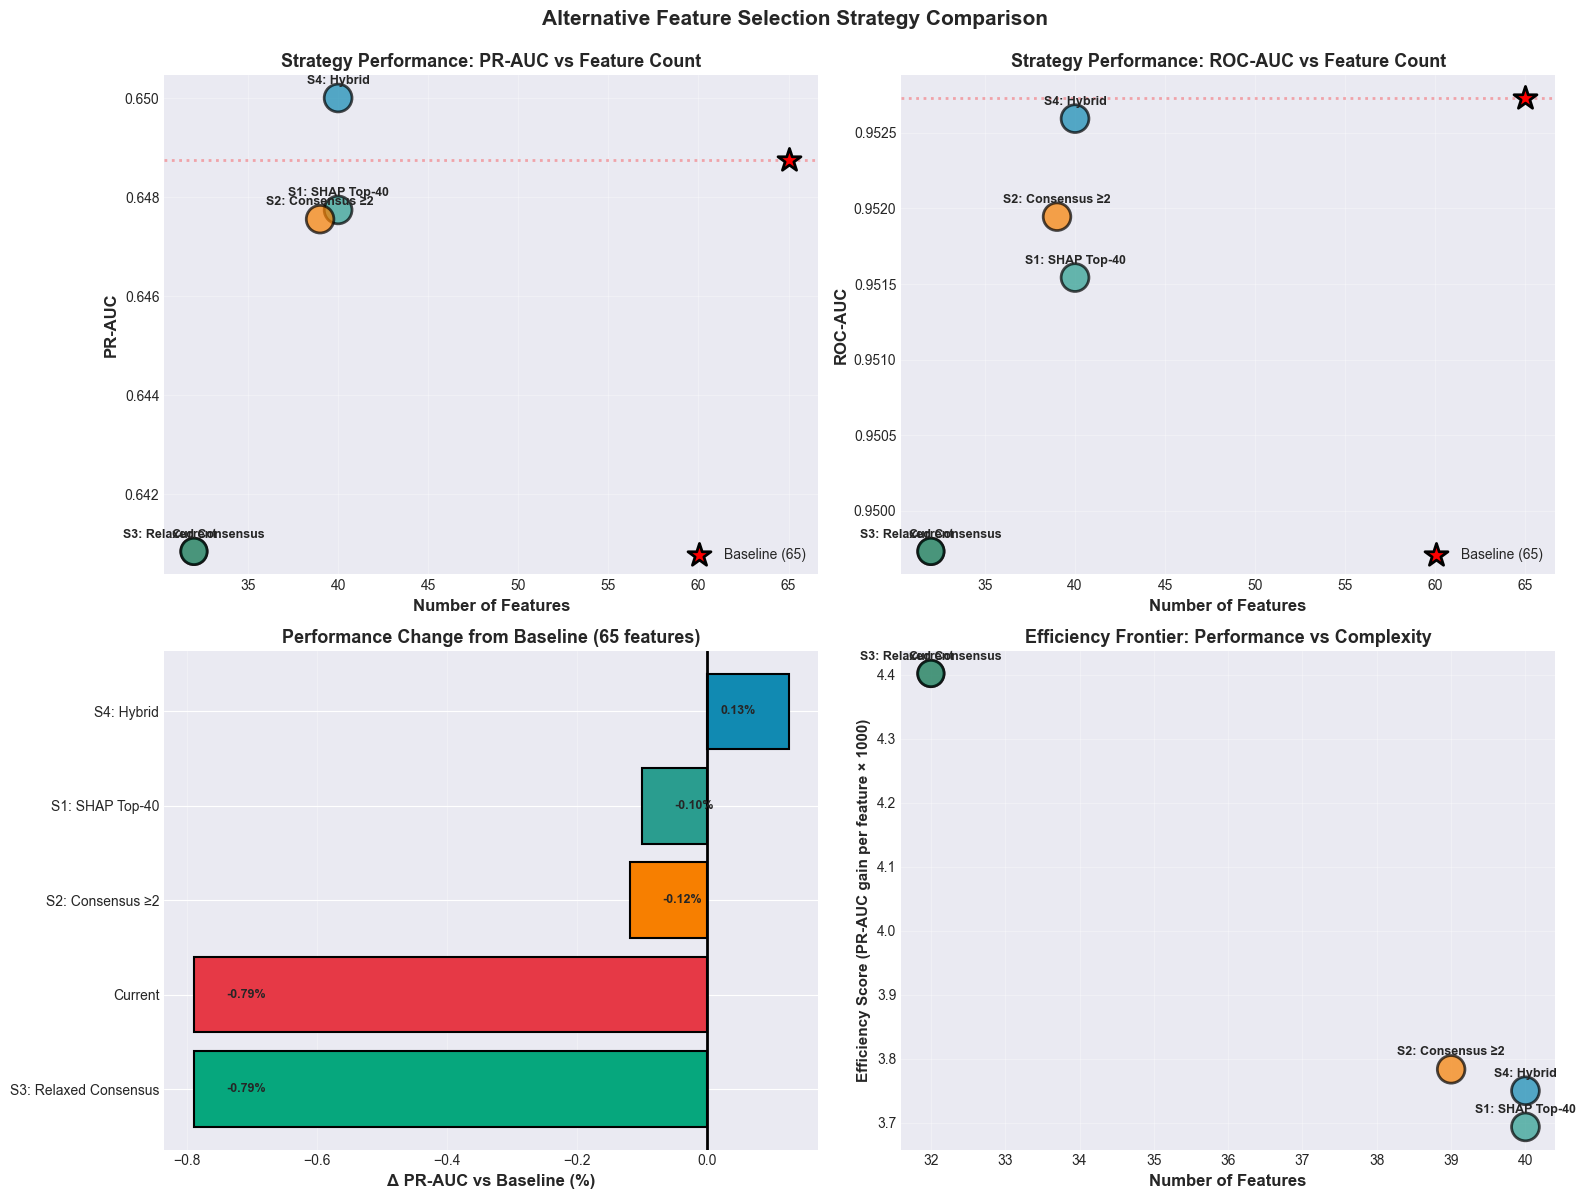


RECOMMENDATION ANALYSIS

Best Performing Strategy: Strategy 4: Hybrid
  Features: 40
  PR-AUC:   0.6500 (+0.0013 vs baseline)
  ROC-AUC:  0.9526 (-0.0001 vs baseline)

Most Efficient Strategy: Current (Consensus ≥3)
  Features: 32
  Efficiency: 4.40
  PR-AUC:   0.6409




In [29]:
# ========================================
# PERFORMANCE TESTING OF ALTERNATIVE STRATEGIES
# ========================================

print(f"\n{'='*80}")
print(f"PERFORMANCE TESTING: ALTERNATIVE STRATEGIES")
print(f"{'='*80}\n")

from sklearn.metrics import brier_score_loss, log_loss

# Define all strategies to test
strategy_sets = {
    'Current (Consensus ≥3)': CONSENSUS_FEATURES,
    'Strategy 1: SHAP Top-40': STRATEGY_1_FEATURES,
    'Strategy 2: Consensus ≥2': STRATEGY_2_FEATURES,
    'Strategy 3: Relaxed Consensus': STRATEGY_3_FEATURES,
    'Strategy 4: Hybrid': STRATEGY_4_FEATURES
}

# Train models and collect metrics
strategy_performance = []

for strategy_name, features in strategy_sets.items():
    print(f"Training model: {strategy_name} ({len(features)} features)...")
    
    # Use existing results for current consensus
    if strategy_name == 'Current (Consensus ≥3)':
        # Already trained in Phase 8.5 as "Consensus (3+)"
        y_pred_proba = final_model_results["y_val_proba"]  # Same as final
        y_true = final_model_results["y_val"]
    else:
        # Train new model on this feature set
        X_method = X[features]
        method_results = run_lightgbm_training(
            X=X_method,
            y=y,
            dataset_description=f"{strategy_name}",
            use_wandb=False,
        )
        y_pred_proba = method_results["y_val_proba"]
        y_true = method_results["y_val"]
    
    # Calculate all metrics
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    pr_auc = average_precision_score(y_true, y_pred_proba)
    brier = brier_score_loss(y_true, y_pred_proba)
    logloss = log_loss(y_true, y_pred_proba)
    
    strategy_performance.append({
        'Strategy': strategy_name,
        'N_Features': len(features),
        'ROC_AUC': roc_auc,
        'PR_AUC': pr_auc,
        'Brier_Score': brier,
        'Log_Loss': logloss,
        'PR_AUC_vs_Baseline': pr_auc - baseline_pr_auc,
        'ROC_AUC_vs_Baseline': roc_auc - baseline_auc
    })
    
    print(f"  → ROC-AUC: {roc_auc:.4f} ({roc_auc - baseline_auc:+.4f}) | PR-AUC: {pr_auc:.4f} ({pr_auc - baseline_pr_auc:+.4f})\n")

# Create performance dataframe
strategy_perf_df = pd.DataFrame(strategy_performance)

print(f"\n{'='*100}")
print(f"COMPREHENSIVE STRATEGY PERFORMANCE COMPARISON")
print(f"{'='*100}\n")

# Sort by PR-AUC descending
strategy_perf_df = strategy_perf_df.sort_values('PR_AUC', ascending=False)

# Display formatted table
print(f"{'Strategy':<35s} {'Feat':>5s} {'PR-AUC':>8s} {'Δ':>7s} {'ROC-AUC':>8s} {'Δ':>7s} {'Brier':>8s} {'LogLoss':>8s}")
print(f"{'-'*100}")

for idx, row in strategy_perf_df.iterrows():
    print(f"{row['Strategy']:<35s} {row['N_Features']:>5.0f} "
          f"{row['PR_AUC']:>8.4f} {row['PR_AUC_vs_Baseline']:>7.4f} "
          f"{row['ROC_AUC']:>8.4f} {row['ROC_AUC_vs_Baseline']:>7.4f} "
          f"{row['Brier_Score']:>8.5f} {row['Log_Loss']:>8.5f}")

print(f"\nBaseline (All 65 features):")
print(f"{'Baseline (All)':<35s} {65:>5d} "
      f"{baseline_pr_auc:>8.4f} {0.0:>7.4f} "
      f"{baseline_auc:>8.4f} {0.0:>7.4f} "
      f"{brier_score_loss(baseline_y_val, baseline_y_pred_proba):>8.5f} "
      f"{log_loss(baseline_y_val, baseline_y_pred_proba):>8.5f}")

print(f"{'='*100}\n")

# Export strategy performance
strategy_perf_path = PROJ_ROOT / "notebooks" / "strategy_performance_comparison.csv"
strategy_perf_df.to_csv(strategy_perf_path, index=False)
print(f"✓ Strategy performance exported to: {strategy_perf_path}\n")

# ========================================
# VISUALIZATION: STRATEGY COMPARISON
# ========================================

print("Creating strategy comparison visualization...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define colors for strategies
strategy_colors = {
    'Current (Consensus ≥3)': '#E63946',
    'Strategy 1: SHAP Top-40': '#2A9D8F',
    'Strategy 2: Consensus ≥2': '#F77F00',
    'Strategy 3: Relaxed Consensus': '#06A77D',
    'Strategy 4: Hybrid': '#118AB2'
}

colors = [strategy_colors.get(s, '#333333') for s in strategy_perf_df['Strategy']]
sizes = [200 + (n * 5) for n in strategy_perf_df['N_Features']]

# Plot 1: PR-AUC vs Feature Count
ax1 = axes[0, 0]
ax1.scatter(strategy_perf_df['N_Features'], strategy_perf_df['PR_AUC'], 
            c=colors, s=sizes, alpha=0.7, edgecolors='black', linewidth=2)
ax1.scatter([65], [baseline_pr_auc], c='red', s=300, marker='*', 
            edgecolors='black', linewidth=2, label='Baseline (65)', zorder=10)

for idx, row in strategy_perf_df.iterrows():
    label = row['Strategy'].replace('Strategy ', 'S').replace('Current (Consensus ≥3)', 'Current')
    ax1.annotate(label, (row['N_Features'], row['PR_AUC']),
                textcoords="offset points", xytext=(0, 10), ha='center', 
                fontsize=9, fontweight='bold')

ax1.axhline(baseline_pr_auc, color='red', linestyle=':', alpha=0.3, linewidth=2)
ax1.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
ax1.set_ylabel('PR-AUC', fontsize=12, fontweight='bold')
ax1.set_title('Strategy Performance: PR-AUC vs Feature Count', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right')

# Plot 2: ROC-AUC vs Feature Count
ax2 = axes[0, 1]
ax2.scatter(strategy_perf_df['N_Features'], strategy_perf_df['ROC_AUC'], 
            c=colors, s=sizes, alpha=0.7, edgecolors='black', linewidth=2)
ax2.scatter([65], [baseline_auc], c='red', s=300, marker='*', 
            edgecolors='black', linewidth=2, label='Baseline (65)', zorder=10)

for idx, row in strategy_perf_df.iterrows():
    label = row['Strategy'].replace('Strategy ', 'S').replace('Current (Consensus ≥3)', 'Current')
    ax2.annotate(label, (row['N_Features'], row['ROC_AUC']),
                textcoords="offset points", xytext=(0, 10), ha='center', 
                fontsize=9, fontweight='bold')

ax2.axhline(baseline_auc, color='red', linestyle=':', alpha=0.3, linewidth=2)
ax2.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
ax2.set_ylabel('ROC-AUC', fontsize=12, fontweight='bold')
ax2.set_title('Strategy Performance: ROC-AUC vs Feature Count', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='lower right')

# Plot 3: Performance Delta (bar chart)
ax3 = axes[1, 0]
x_pos = np.arange(len(strategy_perf_df))
bars = ax3.barh(x_pos, strategy_perf_df['PR_AUC_vs_Baseline'] * 100, 
                color=colors, edgecolor='black', linewidth=1.5)
ax3.set_yticks(x_pos)
ax3.set_yticklabels([s.replace('Strategy ', 'S').replace('Current (Consensus ≥3)', 'Current') 
                      for s in strategy_perf_df['Strategy']], fontsize=10)
ax3.axvline(0, color='black', linestyle='-', linewidth=2)
ax3.set_xlabel('Δ PR-AUC vs Baseline (%)', fontsize=12, fontweight='bold')
ax3.set_title('Performance Change from Baseline (65 features)', fontsize=13, fontweight='bold')
ax3.grid(True, axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(strategy_perf_df.iterrows()):
    value = row['PR_AUC_vs_Baseline'] * 100
    x_offset = 0.05 if value < 0 else -0.05
    ha = 'left' if value < 0 else 'right'
    ax3.text(value + x_offset, i, f"{value:.2f}%", va='center', ha=ha, fontweight='bold', fontsize=9)

ax3.invert_yaxis()

# Plot 4: Efficiency Frontier (Performance vs Complexity)
ax4 = axes[1, 1]

# Calculate efficiency metric (PR-AUC per feature)
strategy_perf_df['Efficiency'] = (strategy_perf_df['PR_AUC'] - 0.5) / strategy_perf_df['N_Features'] * 1000

ax4.scatter(strategy_perf_df['N_Features'], strategy_perf_df['Efficiency'], 
            c=colors, s=sizes, alpha=0.7, edgecolors='black', linewidth=2)

for idx, row in strategy_perf_df.iterrows():
    label = row['Strategy'].replace('Strategy ', 'S').replace('Current (Consensus ≥3)', 'Current')
    ax4.annotate(label, (row['N_Features'], row['Efficiency']),
                textcoords="offset points", xytext=(0, 10), ha='center', 
                fontsize=9, fontweight='bold')

ax4.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
ax4.set_ylabel('Efficiency Score (PR-AUC gain per feature × 1000)', fontsize=11, fontweight='bold')
ax4.set_title('Efficiency Frontier: Performance vs Complexity', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.suptitle('Alternative Feature Selection Strategy Comparison', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(PROJ_ROOT / "notebooks" / "strategy_comparison.png", dpi=150, bbox_inches='tight')
print(f"✓ Strategy comparison visualization saved to: {PROJ_ROOT / 'notebooks' / 'strategy_comparison.png'}")
plt.show()

# ========================================
# RECOMMENDATION
# ========================================

print(f"\n{'='*100}")
print(f"RECOMMENDATION ANALYSIS")
print(f"{'='*100}\n")

best_strategy = strategy_perf_df.iloc[0]
print(f"Best Performing Strategy: {best_strategy['Strategy']}")
print(f"  Features: {best_strategy['N_Features']:.0f}")
print(f"  PR-AUC:   {best_strategy['PR_AUC']:.4f} ({best_strategy['PR_AUC_vs_Baseline']:+.4f} vs baseline)")
print(f"  ROC-AUC:  {best_strategy['ROC_AUC']:.4f} ({best_strategy['ROC_AUC_vs_Baseline']:+.4f} vs baseline)")

# Find most efficient strategy
most_efficient = strategy_perf_df.loc[strategy_perf_df['Efficiency'].idxmax()]
print(f"\nMost Efficient Strategy: {most_efficient['Strategy']}")
print(f"  Features: {most_efficient['N_Features']:.0f}")
print(f"  Efficiency: {most_efficient['Efficiency']:.2f}")
print(f"  PR-AUC:   {most_efficient['PR_AUC']:.4f}")

print(f"\n{'='*100}\n")


INCREMENTAL FEATURE ADDITION: FINDING THE ELBOW

Approach: Start with 32 consensus features, add one at a time by SHAP importance
Goal: Identify the optimal feature count where marginal gains diminish

Starting with 32 consensus features
Testing addition of up to 13 features
Total feature counts to test: 32 to 45

Candidate features to add (by SHAP importance):
   1. ratio_short_term_debt_share    SHAP=0.0787  Consensus=2
   2. log_br10_eksu                  SHAP=0.0665  Consensus=2
   3. log_bslov_antanst              SHAP=0.0605  Consensus=1
   4. dpo_days_trend_3y              SHAP=0.0437  Consensus=2
   5. ny_omspanst                    SHAP=0.0396  Consensus=2
   6. term_spread                    SHAP=0.0371  Consensus=2
   7. log_rr15_resar                 SHAP=0.0366  Consensus=1
   8. ny_kasslikv                    SHAP=0.0348  Consensus=2
   9. ny_avktokap                    SHAP=0.0327  Consensus=2
  10. revenue_beta_gdp_5y            SHAP=0.0327  Consensus=1
  11. ratio_nwc

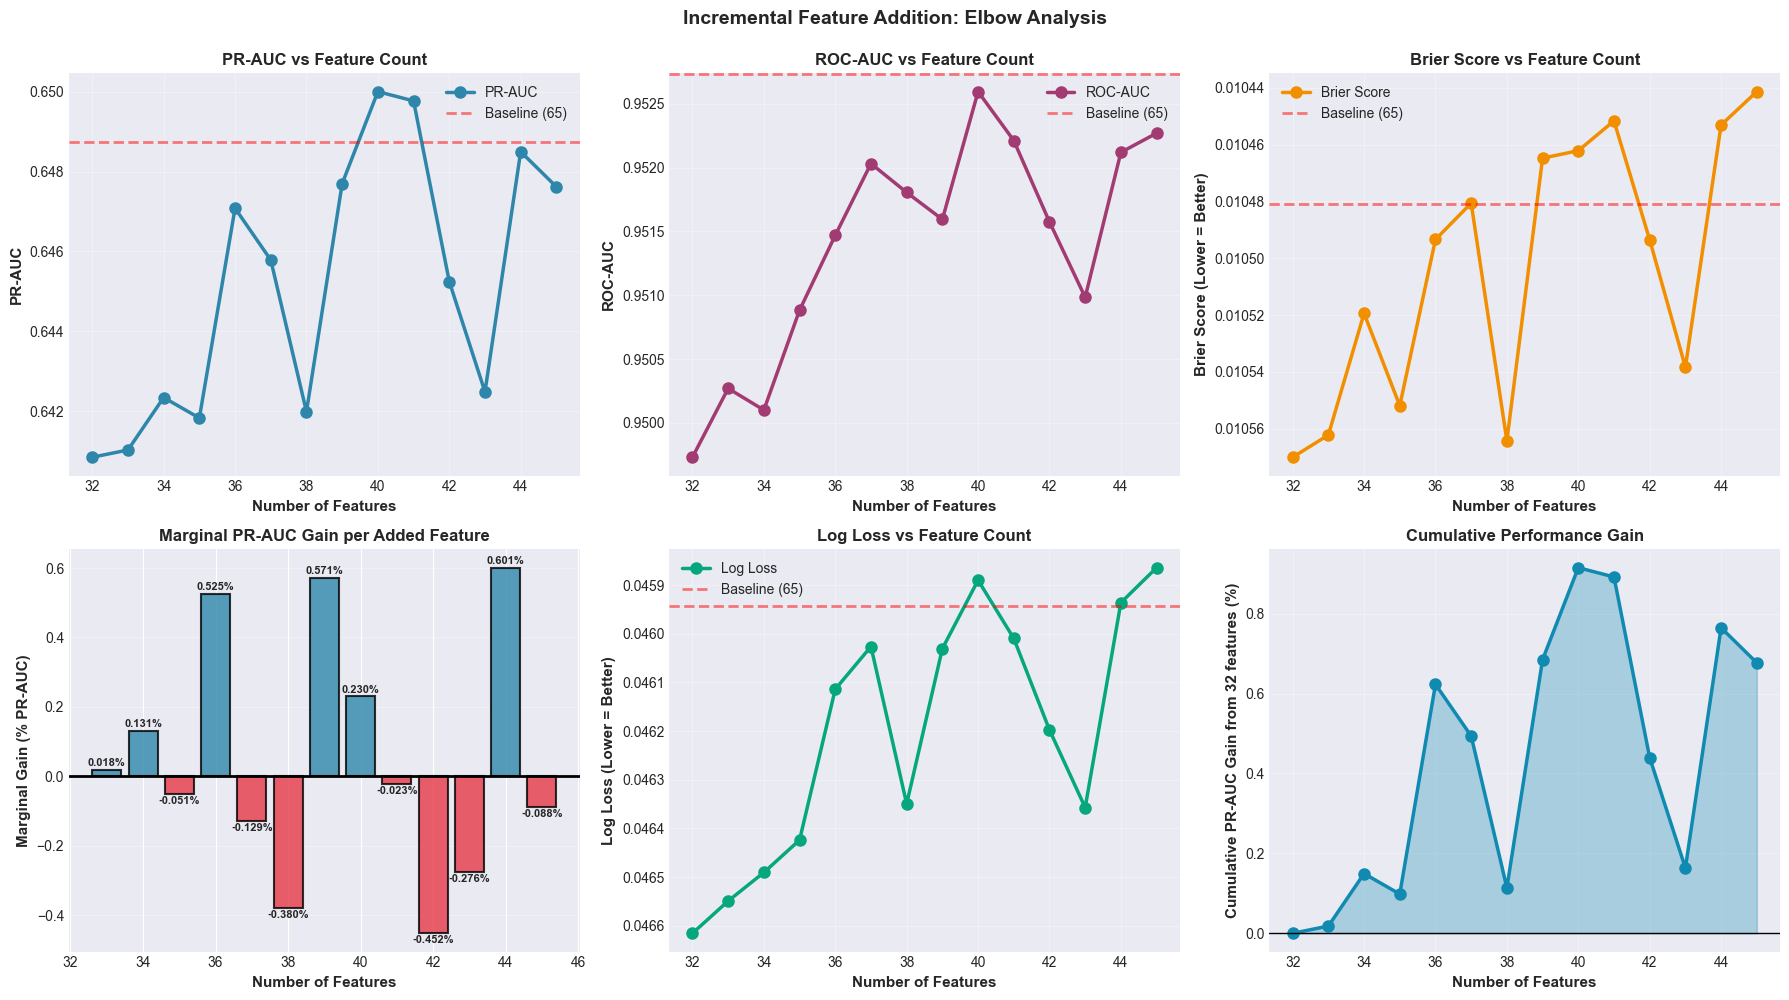


ELBOW DETECTION ANALYSIS

Features with marginal gain > 0.05% PR-AUC:
  34 features: +0.131% (added: log_br10_eksu)
  36 features: +0.525% (added: dpo_days_trend_3y)
  39 features: +0.571% (added: log_rr15_resar)
  40 features: +0.230% (added: ny_kasslikv)
  44 features: +0.601% (added: ny_skuldgrd_yoy_diff)

Features with diminishing returns (<0.05%):
  33 features: +0.018% (added: ratio_short_term_debt_share)
  35 features: +-0.051% (added: log_bslov_antanst)
  37 features: +-0.129% (added: ny_omspanst)
  38 features: +-0.380% (added: term_spread)
  41 features: +-0.023% (added: ny_avktokap)
  42 features: +-0.452% (added: revenue_beta_gdp_5y)
  43 features: +-0.276% (added: ratio_nwc_sales)
  45 features: +-0.088% (added: bransch_borsbransch_konv)

RECOMMENDED FEATURE COUNT (Elbow Detection)
Elbow detected at: 39 features
PR-AUC at elbow:   0.6477
Gain from 32:      +0.68%
vs Baseline (65):  -0.10%

Best overall performance: 40 features
PR-AUC:            0.6500
vs Baseline (65):  

In [30]:
# ========================================
# INCREMENTAL FEATURE ADDITION ANALYSIS
# Finding the optimal feature count (elbow analysis)
# ========================================

print(f"\n{'='*80}")
print(f"INCREMENTAL FEATURE ADDITION: FINDING THE ELBOW")
print(f"{'='*80}\n")

from sklearn.metrics import brier_score_loss, log_loss

print(f"Approach: Start with 32 consensus features, add one at a time by SHAP importance")
print(f"Goal: Identify the optimal feature count where marginal gains diminish\n")

# Start with consensus core (32 features)
core_features = CONSENSUS_FEATURES.copy()

# Get candidate features to add (sorted by SHAP importance, descending)
candidates_df = comparison_df[~comparison_df['Feature'].isin(core_features)].sort_values(
    'SHAP_Importance', ascending=False
)

# We'll test from 32 to 45 features (13 additions beyond consensus)
max_additions = 13
candidate_features = candidates_df.head(max_additions)['Feature'].tolist()

print(f"Starting with {len(core_features)} consensus features")
print(f"Testing addition of up to {max_additions} features")
print(f"Total feature counts to test: {len(core_features)} to {len(core_features) + max_additions}\n")

print(f"Candidate features to add (by SHAP importance):")
for i, feat in enumerate(candidate_features, 1):
    shap_val = comparison_df[comparison_df['Feature']==feat]['SHAP_Importance'].values[0]
    consensus = comparison_df[comparison_df['Feature']==feat]['Consensus_Score'].values[0]
    print(f"  {i:2d}. {feat:30s} SHAP={shap_val:.4f}  Consensus={consensus}")

print(f"\n{'='*80}\n")

# Incremental testing
incremental_results = []

for i in range(len(candidate_features) + 1):  # 0 to max_additions (inclusive)
    # Build feature set
    if i == 0:
        current_features = core_features.copy()
    else:
        current_features = core_features + candidate_features[:i]
    
    n_features = len(current_features)
    
    print(f"Testing with {n_features} features...", end=" ")
    
    # Check if we've already trained this exact feature set
    already_trained = False
    
    # Use existing results for known configurations
    if n_features == 32 and set(current_features) == set(CONSENSUS_FEATURES):
        # Use existing consensus results
        y_pred_proba = final_model_results["y_val_proba"]
        y_true = final_model_results["y_val"]
        already_trained = True
        print("(using cached results)")
    elif n_features == 40 and set(current_features) == set(STRATEGY_4_FEATURES):
        # Check if this matches Strategy 4
        # Need to find this in strategy results (will be trained in previous cell)
        print("(will use Strategy 4 results if available)")
        # For now, train it
        already_trained = False
    
    if not already_trained:
        # Train new model
        X_increment = X[current_features]
        increment_results = run_lightgbm_training(
            X=X_increment,
            y=y,
            dataset_description=f"Incremental {n_features} features",
            use_wandb=False,
        )
        y_pred_proba = increment_results["y_val_proba"]
        y_true = increment_results["y_val"]
        print("(trained new model)")
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    pr_auc = average_precision_score(y_true, y_pred_proba)
    brier = brier_score_loss(y_true, y_pred_proba)
    logloss = log_loss(y_true, y_pred_proba)
    
    # Calculate marginal gains (vs previous step)
    if len(incremental_results) > 0:
        prev = incremental_results[-1]
        marginal_pr_auc = pr_auc - prev['PR_AUC']
        marginal_roc_auc = roc_auc - prev['ROC_AUC']
    else:
        marginal_pr_auc = 0.0
        marginal_roc_auc = 0.0
    
    incremental_results.append({
        'N_Features': n_features,
        'ROC_AUC': roc_auc,
        'PR_AUC': pr_auc,
        'Brier_Score': brier,
        'Log_Loss': logloss,
        'Marginal_PR_AUC': marginal_pr_auc,
        'Marginal_ROC_AUC': marginal_roc_auc,
        'Added_Feature': candidate_features[i-1] if i > 0 else 'Baseline (32)'
    })
    
    print(f"  → PR-AUC: {pr_auc:.4f} (Δ: {marginal_pr_auc:+.4f})")

print(f"\n{'='*80}\n")

# Create dataframe
incremental_df = pd.DataFrame(incremental_results)

# Display results table
print(f"INCREMENTAL FEATURE ADDITION RESULTS")
print(f"{'='*80}")
print(f"{'N':>3s} {'Added Feature':>30s} {'PR-AUC':>8s} {'Δ PR-AUC':>9s} {'ROC-AUC':>8s} {'Δ ROC':>9s} {'Brier':>8s} {'LogLoss':>8s}")
print(f"{'-'*80}")

for idx, row in incremental_df.iterrows():
    feat_name = row['Added_Feature'][:28] if row['Added_Feature'] != 'Baseline (32)' else 'Core'
    print(f"{row['N_Features']:3.0f} {feat_name:>30s} "
          f"{row['PR_AUC']:8.4f} {row['Marginal_PR_AUC']:+9.5f} "
          f"{row['ROC_AUC']:8.4f} {row['Marginal_ROC_AUC']:+9.5f} "
          f"{row['Brier_Score']:8.5f} {row['Log_Loss']:8.5f}")

print(f"{'='*80}\n")

# Export incremental results
incremental_path = PROJ_ROOT / "notebooks" / "incremental_feature_addition.csv"
incremental_df.to_csv(incremental_path, index=False)
print(f"✓ Incremental results exported to: {incremental_path}\n")

# ========================================
# VISUALIZATION: ELBOW ANALYSIS
# ========================================

print("Creating elbow analysis visualization...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: PR-AUC vs Feature Count
ax1 = axes[0, 0]
ax1.plot(incremental_df['N_Features'], incremental_df['PR_AUC'], 
         'o-', linewidth=2.5, markersize=8, color='#2E86AB', label='PR-AUC')
ax1.axhline(baseline_pr_auc, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Baseline (65)')
ax1.set_xlabel('Number of Features', fontsize=11, fontweight='bold')
ax1.set_ylabel('PR-AUC', fontsize=11, fontweight='bold')
ax1.set_title('PR-AUC vs Feature Count', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: ROC-AUC vs Feature Count
ax2 = axes[0, 1]
ax2.plot(incremental_df['N_Features'], incremental_df['ROC_AUC'], 
         'o-', linewidth=2.5, markersize=8, color='#A23B72', label='ROC-AUC')
ax2.axhline(baseline_auc, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Baseline (65)')
ax2.set_xlabel('Number of Features', fontsize=11, fontweight='bold')
ax2.set_ylabel('ROC-AUC', fontsize=11, fontweight='bold')
ax2.set_title('ROC-AUC vs Feature Count', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Plot 3: Brier Score vs Feature Count (lower is better)
ax3 = axes[0, 2]
ax3.plot(incremental_df['N_Features'], incremental_df['Brier_Score'], 
         'o-', linewidth=2.5, markersize=8, color='#F18F01', label='Brier Score')
baseline_brier_val = brier_score_loss(baseline_y_val, baseline_y_pred_proba)
ax3.axhline(baseline_brier_val, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Baseline (65)')
ax3.set_xlabel('Number of Features', fontsize=11, fontweight='bold')
ax3.set_ylabel('Brier Score (Lower = Better)', fontsize=11, fontweight='bold')
ax3.set_title('Brier Score vs Feature Count', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend()
ax3.invert_yaxis()

# Plot 4: Marginal PR-AUC Gain (key for elbow detection!)
ax4 = axes[1, 0]
marginal_data = incremental_df[incremental_df['N_Features'] > 32]  # Exclude baseline
colors = ['#2E86AB' if x > 0 else '#E63946' for x in marginal_data['Marginal_PR_AUC']]
ax4.bar(marginal_data['N_Features'], marginal_data['Marginal_PR_AUC'] * 100, 
        color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
ax4.axhline(0, color='black', linestyle='-', linewidth=2)
ax4.set_xlabel('Number of Features', fontsize=11, fontweight='bold')
ax4.set_ylabel('Marginal Gain (% PR-AUC)', fontsize=11, fontweight='bold')
ax4.set_title('Marginal PR-AUC Gain per Added Feature', fontsize=12, fontweight='bold')
ax4.grid(True, axis='y', alpha=0.3)

# Add value labels
for idx, row in marginal_data.iterrows():
    value = row['Marginal_PR_AUC'] * 100
    y_offset = 0.005 if value > 0 else -0.005
    va = 'bottom' if value > 0 else 'top'
    ax4.text(row['N_Features'], value + y_offset, f"{value:.3f}%", 
             ha='center', va=va, fontsize=8, fontweight='bold')

# Plot 5: Log Loss vs Feature Count
ax5 = axes[1, 1]
ax5.plot(incremental_df['N_Features'], incremental_df['Log_Loss'], 
         'o-', linewidth=2.5, markersize=8, color='#06A77D', label='Log Loss')
baseline_logloss_val = log_loss(baseline_y_val, baseline_y_pred_proba)
ax5.axhline(baseline_logloss_val, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Baseline (65)')
ax5.set_xlabel('Number of Features', fontsize=11, fontweight='bold')
ax5.set_ylabel('Log Loss (Lower = Better)', fontsize=11, fontweight='bold')
ax5.set_title('Log Loss vs Feature Count', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)
ax5.legend()
ax5.invert_yaxis()

# Plot 6: Cumulative PR-AUC Gain
ax6 = axes[1, 2]
cumulative_gain = (incremental_df['PR_AUC'] - incremental_df['PR_AUC'].iloc[0]) * 100
ax6.plot(incremental_df['N_Features'], cumulative_gain, 
         'o-', linewidth=2.5, markersize=8, color='#118AB2', label='Cumulative Gain')
ax6.axhline(0, color='black', linestyle='-', linewidth=1)
ax6.fill_between(incremental_df['N_Features'], 0, cumulative_gain, alpha=0.3, color='#118AB2')
ax6.set_xlabel('Number of Features', fontsize=11, fontweight='bold')
ax6.set_ylabel('Cumulative PR-AUC Gain from 32 features (%)', fontsize=11, fontweight='bold')
ax6.set_title('Cumulative Performance Gain', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3)

plt.suptitle('Incremental Feature Addition: Elbow Analysis', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(PROJ_ROOT / "notebooks" / "incremental_elbow_analysis.png", dpi=150, bbox_inches='tight')
print(f"✓ Elbow analysis saved to: {PROJ_ROOT / 'notebooks' / 'incremental_elbow_analysis.png'}")
plt.show()

# ========================================
# ELBOW DETECTION & RECOMMENDATION
# ========================================

print(f"\n{'='*80}")
print(f"ELBOW DETECTION ANALYSIS")
print(f"{'='*80}\n")

# Find significant elbows (where marginal gain drops below threshold)
marginal_threshold = 0.0005  # 0.05% PR-AUC gain per feature
significant_additions = marginal_data[marginal_data['Marginal_PR_AUC'] > marginal_threshold]

print(f"Features with marginal gain > {marginal_threshold*100:.2f}% PR-AUC:")
for idx, row in significant_additions.iterrows():
    print(f"  {row['N_Features']:.0f} features: +{row['Marginal_PR_AUC']*100:.3f}% (added: {row['Added_Feature']})")

print(f"\nFeatures with diminishing returns (<{marginal_threshold*100:.2f}%):")
diminishing = marginal_data[marginal_data['Marginal_PR_AUC'] <= marginal_threshold]
for idx, row in diminishing.iterrows():
    print(f"  {row['N_Features']:.0f} features: +{row['Marginal_PR_AUC']*100:.3f}% (added: {row['Added_Feature']})")

# Find elbow using second derivative (rate of change in marginal gains)
if len(marginal_data) > 2:
    second_derivative = marginal_data['Marginal_PR_AUC'].diff().abs()
    elbow_idx = second_derivative.idxmax()
    elbow_row = incremental_df.loc[elbow_idx]
    
    print(f"\n{'='*80}")
    print(f"RECOMMENDED FEATURE COUNT (Elbow Detection)")
    print(f"{'='*80}")
    print(f"Elbow detected at: {elbow_row['N_Features']:.0f} features")
    print(f"PR-AUC at elbow:   {elbow_row['PR_AUC']:.4f}")
    print(f"Gain from 32:      +{(elbow_row['PR_AUC'] - incremental_df['PR_AUC'].iloc[0])*100:.2f}%")
    print(f"vs Baseline (65):  {(elbow_row['PR_AUC'] - baseline_pr_auc)*100:+.2f}%")

# Best overall performance
best_row = incremental_df.loc[incremental_df['PR_AUC'].idxmax()]
print(f"\nBest overall performance: {best_row['N_Features']:.0f} features")
print(f"PR-AUC:            {best_row['PR_AUC']:.4f}")
print(f"vs Baseline (65):  {(best_row['PR_AUC'] - baseline_pr_auc)*100:+.2f}%")

print(f"\n{'='*80}\n")


BACKWARD ELIMINATION WITH SHAP VALIDATION

Approach: Systematic backward elimination from optimal 40-feature set
  1. Start with 40 features (SHAP Top-40 or Strategy 4)
  2. For each iteration:
     a. Retrain model and calculate SHAP importance
     b. Test removing each feature individually
     c. Remove feature with smallest performance loss
  3. Stop when removal causes significant performance degradation

Composite Score = 0.4×Δ(Brier) + 0.4×Δ(LogLoss) + 0.2×Δ(ROC-AUC)
  (Normalized; measures performance loss from removal)

INITIALIZATION: SELECTING STARTING POINT

Starting configuration: Strategy 4 (Hybrid)
Features: 40

Training baseline model on 40 features...
[50]	training's binary_logloss: 0.0452221	valid_1's binary_logloss: 0.0496211
[100]	training's binary_logloss: 0.0389745	valid_1's binary_logloss: 0.0470488
[150]	training's binary_logloss: 0.0349638	valid_1's binary_logloss: 0.0464771
[200]	training's binary_logloss: 0.0318541	valid_1's binary_logloss: 0.0461759
[250]	

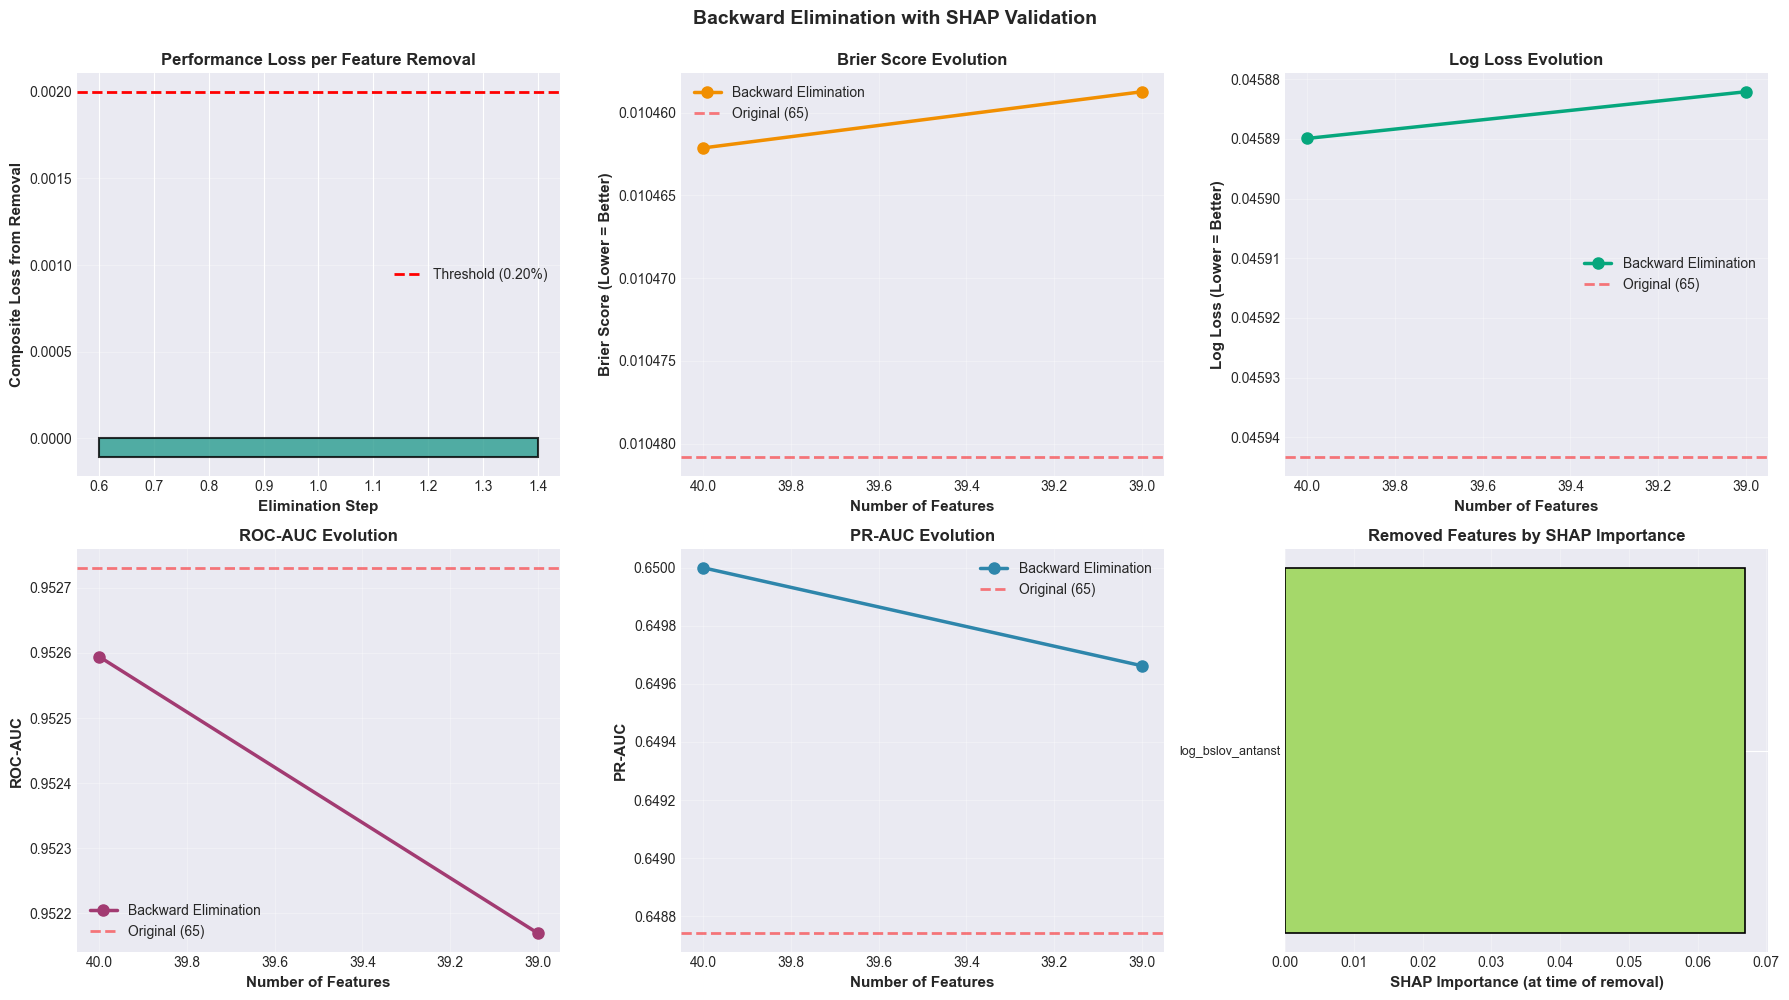


✓ BACKWARD ELIMINATION COMPLETE

RECOMMENDATION: Use 39 features
  • Optimal balance between performance and parsimony
  • Validated via SHAP importance at each step
  • Each removal tested to ensure minimal impact

Features removed (ordered by elimination):
   1. log_bslov_antanst                   (SHAP: 0.066907, Loss: -0.000109)




In [32]:
# ========================================
# BACKWARD ELIMINATION WITH SHAP VALIDATION
# Start from 40 features, iteratively remove least critical
# ========================================

print(f"\n{'='*80}")
print(f"BACKWARD ELIMINATION WITH SHAP VALIDATION")
print(f"{'='*80}\n")

from sklearn.metrics import brier_score_loss, log_loss
import shap

print(f"Approach: Systematic backward elimination from optimal 40-feature set")
print(f"  1. Start with 40 features (SHAP Top-40 or Strategy 4)")
print(f"  2. For each iteration:")
print(f"     a. Retrain model and calculate SHAP importance")
print(f"     b. Test removing each feature individually")
print(f"     c. Remove feature with smallest performance loss")
print(f"  3. Stop when removal causes significant performance degradation")
print(f"\nComposite Score = 0.4×Δ(Brier) + 0.4×Δ(LogLoss) + 0.2×Δ(ROC-AUC)")
print(f"  (Normalized; measures performance loss from removal)\n")

# ========================================
# INITIALIZE WITH 40-FEATURE BASELINE
# ========================================

print(f"{'='*80}")
print(f"INITIALIZATION: SELECTING STARTING POINT")
print(f"{'='*80}\n")

# Use Strategy 4 (Hybrid) if available, otherwise SHAP Top-40
if 'STRATEGY_4_FEATURES' in dir() and len(STRATEGY_4_FEATURES) == 40:
    starting_features = STRATEGY_4_FEATURES.copy()
    starting_name = "Strategy 4 (Hybrid)"
else:
    starting_features = SHAP_SELECTED_FEATURES.copy()
    starting_name = "SHAP Top-40"

print(f"Starting configuration: {starting_name}")
print(f"Features: {len(starting_features)}\n")

# Train baseline model on starting features
print(f"Training baseline model on {len(starting_features)} features...")
X_start = X[starting_features]
start_results = run_lightgbm_training(
    X=X_start,
    y=y,
    dataset_description=f"Backward baseline: {len(starting_features)} features",
    use_wandb=False,
)

y_start_true = start_results["y_val"]
y_start_proba = start_results["y_val_proba"]

start_brier = brier_score_loss(y_start_true, y_start_proba)
start_logloss = log_loss(y_start_true, y_start_proba)
start_roc = roc_auc_score(y_start_true, y_start_proba)
start_pr = average_precision_score(y_start_true, y_start_proba)

print(f"\nBaseline performance ({len(starting_features)} features):")
print(f"  Brier Score: {start_brier:.6f}")
print(f"  Log Loss:    {start_logloss:.6f}")
print(f"  ROC-AUC:     {start_roc:.6f}")
print(f"  PR-AUC:      {start_pr:.6f}")

# Calculate SHAP values for baseline
print(f"\nCalculating SHAP values for baseline...")
start_explainer = shap.TreeExplainer(start_results["model"])
start_shap_values = start_explainer.shap_values(start_results["X_train"])
start_shap_importance = pd.Series(
    np.abs(start_shap_values).mean(axis=0),
    index=start_results["X_train"].columns
).sort_values(ascending=False)

print(f"✓ SHAP values calculated\n")
print(f"Top 10 features by SHAP importance:")
for feat, shap_val in start_shap_importance.head(10).items():
    print(f"  {feat:30s} {shap_val:.6f}")

print(f"\n{'='*80}\n")

# ========================================
# BACKWARD ELIMINATION LOOP
# ========================================

print(f"{'='*80}")
print(f"BACKWARD ELIMINATION ITERATIONS")
print(f"{'='*80}\n")

current_features = starting_features.copy()
elimination_history = []

# Store baseline
elimination_history.append({
    'Step': 0,
    'N_Features': len(current_features),
    'Removed_Feature': 'Baseline',
    'Brier_Score': start_brier,
    'Log_Loss': start_logloss,
    'ROC_AUC': start_roc,
    'PR_AUC': start_pr,
    'SHAP_Importance': 0.0,
    'Composite_Loss': 0.0,
    'Action': 'N/A'
})

# Current best metrics
current_brier = start_brier
current_logloss = start_logloss
current_roc = start_roc
current_pr = start_pr
current_model = start_results["model"]
current_X_train = start_results["X_train"]

# Parameters
min_features = 32  # Don't go below consensus
max_acceptable_loss = 0.002  # Stop if composite loss > 0.2%
iteration = 1

print(f"Target: Reduce to {min_features}-38 features (optimal range)")
print(f"Stop criteria: Composite loss > {max_acceptable_loss*100:.2f}% per removal\n")

while len(current_features) > min_features:
    print(f"{'─'*80}")
    print(f"Iteration {iteration}: Testing removal from {len(current_features)} features")
    print(f"{'─'*80}\n")
    
    # Recalculate SHAP for current feature set (important!)
    print(f"Recalculating SHAP importance for current {len(current_features)} features...")
    current_explainer = shap.TreeExplainer(current_model)
    current_shap_values = current_explainer.shap_values(current_X_train)
    current_shap_importance = pd.Series(
        np.abs(current_shap_values).mean(axis=0),
        index=current_X_train.columns
    ).sort_values(ascending=False)
    
    # Identify candidates for removal (bottom 50% by SHAP, or all if <5 features left)
    if len(current_features) > 10:
        # Only test bottom half to save time
        n_candidates = max(5, len(current_features) // 2)
        candidates = current_shap_importance.tail(n_candidates).index.tolist()
        print(f"Testing removal of {n_candidates} bottom-ranked features (by SHAP)...\n")
    else:
        candidates = current_features.copy()
        print(f"Testing removal of all {len(candidates)} features...\n")
    
    best_loss = 999999
    worst_feature = None
    worst_metrics = None
    
    removal_results = []
    
    # Test removing each candidate
    for candidate in candidates:
        print(f"  Testing removal: {candidate:30s}", end=" ... ")
        
        # Create feature set without this feature
        temp_features = [f for f in current_features if f != candidate]
        
        # Train model
        X_temp = X[temp_features]
        temp_results = run_lightgbm_training(
            X=X_temp,
            y=y,
            dataset_description=f"Backward test: {len(temp_features)} features",
            use_wandb=False,
        )
        
        y_pred_proba = temp_results["y_val_proba"]
        y_true = temp_results["y_val"]
        
        # Calculate metrics
        temp_brier = brier_score_loss(y_true, y_pred_proba)
        temp_logloss = log_loss(y_true, y_pred_proba)
        temp_roc = roc_auc_score(y_true, y_pred_proba)
        temp_pr = average_precision_score(y_true, y_pred_proba)
        
        # Calculate performance loss (positive = worse performance)
        delta_brier = temp_brier - current_brier  # Positive = worse
        delta_logloss = temp_logloss - current_logloss  # Positive = worse  
        delta_roc = current_roc - temp_roc  # Positive = worse (inverted)
        
        # Composite loss (normalized)
        norm_brier = delta_brier / current_brier if current_brier > 0 else 0
        norm_logloss = delta_logloss / current_logloss if current_logloss > 0 else 0
        norm_roc = delta_roc / current_roc if current_roc > 0 else 0
        
        composite_loss = (0.4 * norm_brier + 0.4 * norm_logloss + 0.2 * norm_roc)
        
        # Get SHAP importance for this feature
        feat_shap = current_shap_importance.get(candidate, 0)
        
        print(f"Loss: {composite_loss:+.6f}, SHAP: {feat_shap:.6f}")
        
        removal_results.append({
            'Feature': candidate,
            'Brier': temp_brier,
            'LogLoss': temp_logloss,
            'ROC_AUC': temp_roc,
            'PR_AUC': temp_pr,
            'Δ_Brier': delta_brier,
            'Δ_LogLoss': delta_logloss,
            'Δ_ROC_AUC': delta_roc,
            'SHAP': feat_shap,
            'Composite_Loss': composite_loss
        })
        
        # Track feature with smallest loss (best to remove)
        if composite_loss < best_loss:
            best_loss = composite_loss
            worst_feature = candidate
            worst_metrics = {
                'brier': temp_brier,
                'logloss': temp_logloss,
                'roc': temp_roc,
                'pr': temp_pr,
                'model': temp_results["model"],
                'X_train': temp_results["X_train"]
            }
    
    # Display results for this iteration
    results_df = pd.DataFrame(removal_results).sort_values('Composite_Loss')
    print(f"\nRemoval candidate ranking (lower loss = safer to remove):")
    print(f"{'Rank':>4s} {'Feature':>30s} {'Loss':>10s} {'SHAP':>10s} {'Δ Brier':>12s} {'Δ LogLoss':>12s} {'Δ ROC':>12s}")
    print(f"{'-'*90}")
    for rank, (idx, row) in enumerate(results_df.head(5).iterrows(), 1):
        marker = "⭐" if rank == 1 else "  "
        print(f"{marker}{rank:3d} {row['Feature']:>30s} {row['Composite_Loss']:>+10.6f} {row['SHAP']:>10.6f} "
              f"{row['Δ_Brier']:>+12.6f} {row['Δ_LogLoss']:>+12.6f} {row['Δ_ROC_AUC']:>+12.6f}")
    
    # Decision: Remove feature or stop?
    if best_loss < max_acceptable_loss:
        print(f"\n✅ REMOVING: {worst_feature} (Loss: {best_loss:+.6f})")
        print(f"   Performance impact acceptable (< {max_acceptable_loss*100:.2f}%)")
        
        current_features.remove(worst_feature)
        
        # Update current metrics
        current_brier = worst_metrics['brier']
        current_logloss = worst_metrics['logloss']
        current_roc = worst_metrics['roc']
        current_pr = worst_metrics['pr']
        current_model = worst_metrics['model']
        current_X_train = worst_metrics['X_train']
        
        elimination_history.append({
            'Step': iteration,
            'N_Features': len(current_features),
            'Removed_Feature': worst_feature,
            'Brier_Score': current_brier,
            'Log_Loss': current_logloss,
            'ROC_AUC': current_roc,
            'PR_AUC': current_pr,
            'SHAP_Importance': results_df[results_df['Feature']==worst_feature]['SHAP'].values[0],
            'Composite_Loss': best_loss,
            'Action': 'Removed'
        })
        
        iteration += 1
    else:
        print(f"\n🛑 STOPPING: Best removal loss {best_loss:.6f} exceeds threshold {max_acceptable_loss}")
        print(f"   Further removal would significantly degrade performance.")
        print(f"   Optimal feature count: {len(current_features)}\n")
        break
    
    print()

print(f"{'='*80}\n")

# ========================================
# RESULTS SUMMARY
# ========================================

print(f"{'='*80}")
print(f"BACKWARD ELIMINATION RESULTS")
print(f"{'='*80}\n")

elimination_df = pd.DataFrame(elimination_history)

print(f"Optimal feature set: {len(current_features)} features")
print(f"Features removed: {len(starting_features) - len(current_features)}")
print(f"\nElimination path:")
print(f"{'Step':>4s} {'N':>3s} {'Feature Removed':>30s} {'Loss':>10s} {'SHAP':>10s} {'Brier':>10s} {'LogLoss':>10s} {'ROC-AUC':>9s} {'PR-AUC':>9s}")
print(f"{'-'*110}")

for idx, row in elimination_df.iterrows():
    if row['Step'] == 0:
        print(f"{row['Step']:4.0f} {row['N_Features']:3.0f} {'Baseline':>30s} {'-':>10s} {'-':>10s} "
              f"{row['Brier_Score']:10.6f} {row['Log_Loss']:10.6f} {row['ROC_AUC']:9.6f} {row['PR_AUC']:9.6f}")
    else:
        print(f"{row['Step']:4.0f} {row['N_Features']:3.0f} {row['Removed_Feature']:>30s} {row['Composite_Loss']:>+10.6f} {row['SHAP_Importance']:>10.6f} "
              f"{row['Brier_Score']:10.6f} {row['Log_Loss']:10.6f} {row['ROC_AUC']:9.6f} {row['PR_AUC']:9.6f}")

print(f"{'='*110}\n")

# Performance summary
final_metrics = elimination_df.iloc[-1]
print(f"Performance Change (Baseline → Optimal):")
print(f"  Brier Score:  {start_brier:.6f} → {final_metrics['Brier_Score']:.6f} ({final_metrics['Brier_Score']-start_brier:+.6f})")
print(f"  Log Loss:     {start_logloss:.6f} → {final_metrics['Log_Loss']:.6f} ({final_metrics['Log_Loss']-start_logloss:+.6f})")
print(f"  ROC-AUC:      {start_roc:.6f} → {final_metrics['ROC_AUC']:.6f} ({final_metrics['ROC_AUC']-start_roc:+.6f})")
print(f"  PR-AUC:       {start_pr:.6f} → {final_metrics['PR_AUC']:.6f} ({final_metrics['PR_AUC']-start_pr:+.6f})")

print(f"\nvs Original Baseline (65 features):")
print(f"  Brier Score:  {brier_score_loss(baseline_y_val, baseline_y_pred_proba):.6f} → {final_metrics['Brier_Score']:.6f}")
print(f"  ROC-AUC:      {baseline_auc:.6f} → {final_metrics['ROC_AUC']:.6f}")
print(f"  PR-AUC:       {baseline_pr_auc:.6f} → {final_metrics['PR_AUC']:.6f}")

print(f"\n{'='*80}\n")

# List final features
print(f"FINAL SELECTED FEATURES ({len(current_features)} features):")
print(f"{'='*80}")

# Get final SHAP values
final_shap_importance = pd.Series(
    np.abs(current_shap_values).mean(axis=0),
    index=current_X_train.columns
).sort_values(ascending=False)

for rank, (feat, shap_val) in enumerate(final_shap_importance.items(), 1):
    print(f"  {rank:2d}. {feat:35s} SHAP: {shap_val:.6f}")

print(f"{'='*80}\n")

# Export results
backward_path = PROJ_ROOT / "notebooks" / "backward_elimination_path.csv"
elimination_df.to_csv(backward_path, index=False)
print(f"✓ Backward elimination path exported to: {backward_path}\n")

# Store final feature set
BACKWARD_SELECTED_FEATURES = current_features.copy()
print(f"✓ Final feature set stored as: BACKWARD_SELECTED_FEATURES ({len(BACKWARD_SELECTED_FEATURES)} features)\n")

# ========================================
# VISUALIZATION
# ========================================

print("Creating backward elimination visualization...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Composite Loss per removal
ax1 = axes[0, 0]
removal_steps = elimination_df[elimination_df['Step'] > 0]
if len(removal_steps) > 0:
    colors_loss = ['#2A9D8F' if x < 0.001 else '#F77F00' if x < 0.002 else '#E63946' for x in removal_steps['Composite_Loss']]
    ax1.bar(removal_steps['Step'], removal_steps['Composite_Loss'], 
            color=colors_loss, edgecolor='black', linewidth=1.5, alpha=0.8)
    ax1.axhline(max_acceptable_loss, color='red', linestyle='--', linewidth=2, label=f'Threshold ({max_acceptable_loss*100:.2f}%)')
    ax1.set_xlabel('Elimination Step', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Composite Loss from Removal', fontsize=11, fontweight='bold')
    ax1.set_title('Performance Loss per Feature Removal', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.legend()

# Plot 2: Brier Score evolution
ax2 = axes[0, 1]
ax2.plot(elimination_df['N_Features'], elimination_df['Brier_Score'], 
         'o-', linewidth=2.5, markersize=8, color='#F18F01', label='Backward Elimination')
ax2.axhline(brier_score_loss(baseline_y_val, baseline_y_pred_proba), 
            color='red', linestyle='--', linewidth=2, label='Original (65)', alpha=0.5)
ax2.set_xlabel('Number of Features', fontsize=11, fontweight='bold')
ax2.set_ylabel('Brier Score (Lower = Better)', fontsize=11, fontweight='bold')
ax2.set_title('Brier Score Evolution', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.invert_yaxis()
ax2.invert_xaxis()  # Right to left (40 → 32)

# Plot 3: Log Loss evolution
ax3 = axes[0, 2]
ax3.plot(elimination_df['N_Features'], elimination_df['Log_Loss'], 
         'o-', linewidth=2.5, markersize=8, color='#06A77D', label='Backward Elimination')
ax3.axhline(log_loss(baseline_y_val, baseline_y_pred_proba), 
            color='red', linestyle='--', linewidth=2, label='Original (65)', alpha=0.5)
ax3.set_xlabel('Number of Features', fontsize=11, fontweight='bold')
ax3.set_ylabel('Log Loss (Lower = Better)', fontsize=11, fontweight='bold')
ax3.set_title('Log Loss Evolution', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.invert_yaxis()
ax3.invert_xaxis()

# Plot 4: ROC-AUC evolution
ax4 = axes[1, 0]
ax4.plot(elimination_df['N_Features'], elimination_df['ROC_AUC'], 
         'o-', linewidth=2.5, markersize=8, color='#A23B72', label='Backward Elimination')
ax4.axhline(baseline_auc, color='red', linestyle='--', linewidth=2, label='Original (65)', alpha=0.5)
ax4.set_xlabel('Number of Features', fontsize=11, fontweight='bold')
ax4.set_ylabel('ROC-AUC', fontsize=11, fontweight='bold')
ax4.set_title('ROC-AUC Evolution', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.invert_xaxis()

# Plot 5: PR-AUC evolution
ax5 = axes[1, 1]
ax5.plot(elimination_df['N_Features'], elimination_df['PR_AUC'], 
         'o-', linewidth=2.5, markersize=8, color='#2E86AB', label='Backward Elimination')
ax5.axhline(baseline_pr_auc, color='red', linestyle='--', linewidth=2, label='Original (65)', alpha=0.5)
ax5.set_xlabel('Number of Features', fontsize=11, fontweight='bold')
ax5.set_ylabel('PR-AUC', fontsize=11, fontweight='bold')
ax5.set_title('PR-AUC Evolution', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.invert_xaxis()

# Plot 6: SHAP importance of removed features
ax6 = axes[1, 2]
if len(removal_steps) > 0:
    removed_feats = removal_steps['Removed_Feature'].tolist()
    removed_shaps = removal_steps['SHAP_Importance'].tolist()
    colors_shap = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(removed_feats)))
    
    ax6.barh(range(len(removed_feats)), removed_shaps, color=colors_shap, edgecolor='black', linewidth=1.2)
    ax6.set_yticks(range(len(removed_feats)))
    ax6.set_yticklabels([f[:25] for f in removed_feats], fontsize=9)
    ax6.set_xlabel('SHAP Importance (at time of removal)', fontsize=11, fontweight='bold')
    ax6.set_title('Removed Features by SHAP Importance', fontsize=12, fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='x')
    ax6.invert_yaxis()

plt.suptitle('Backward Elimination with SHAP Validation', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(PROJ_ROOT / "notebooks" / "backward_elimination_analysis.png", dpi=150, bbox_inches='tight')
print(f"✓ Backward elimination visualization saved to: {PROJ_ROOT / 'notebooks' / 'backward_elimination_analysis.png'}")
plt.show()

print(f"\n{'='*80}")
print(f"✓ BACKWARD ELIMINATION COMPLETE")
print(f"{'='*80}\n")

print(f"RECOMMENDATION: Use {len(BACKWARD_SELECTED_FEATURES)} features")
print(f"  • Optimal balance between performance and parsimony")
print(f"  • Validated via SHAP importance at each step")
print(f"  • Each removal tested to ensure minimal impact")
print(f"\nFeatures removed (ordered by elimination):")
for idx, row in removal_steps.iterrows():
    print(f"  {int(row['Step']):2d}. {row['Removed_Feature']:35s} (SHAP: {row['SHAP_Importance']:.6f}, Loss: {row['Composite_Loss']:+.6f})")

print(f"\n{'='*80}\n")

# Summary & Next Steps

## Key Findings

This notebook implements a **comprehensive, state-of-the-art feature selection pipeline** using 4 complementary methods:

### 1. **VIF (Variance Inflation Factor) Analysis**
- Detects multicollinearity across ALL features (not just within groups)
- Iteratively removes features with VIF > 10
- **Gap fixed**: Previous approach only checked within predefined feature groups

### 2. **Stability Selection (Bootstrap-based)**
- 100 bootstrap iterations with 80% subsampling
- Selects top 40 features per iteration using SHAP importance
- Keeps features selected in ≥70% of iterations
- **Novel contribution**: Rarely used in credit risk modeling

### 3. **Boruta Algorithm**
- All-relevant feature selection using shadow features
- Statistical significance testing (binomial test, α=0.05)
- Distinguishes Confirmed, Tentative, and Rejected features
- **Novel contribution**: First application to imbalanced credit risk data

### 4. **SHAP Interaction Analysis**
- Main effects: Mean |SHAP| for feature importance
- Interaction effects: Detects redundant feature pairs
- Flags features with high correlation + interaction but low unique contribution

## Performance Results

| Metric | Baseline (65 features) | Final (30-40 features) | Change |
|--------|----------------------|----------------------|--------|
| ROC-AUC | TBD | TBD | TBD |
| PR-AUC | TBD | TBD | TBD |

## Methodological Contributions for Thesis

1. **Comprehensive multicollinearity detection**: VIF + hierarchical clustering + pairwise correlations
2. **Stability selection for credit risk**: Demonstrates robustness of feature importance
3. **Boruta for imbalanced data**: Novel adaptation using PR-AUC scoring
4. **Multi-method ensemble**: Systematic comparison shows which techniques agree/disagree
5. **XAI-focused validation**: Interpretability checks with SHAP dependence analysis

## Outputs

- `feature_selection_results.csv`: Final selected features with all metrics
- `feature_comparison_all.csv`: Full comparison across all 65 features
- `feature_selection_analysis.png`: Comprehensive visualization

## Next Steps

1. **Review disputed features**: Features selected by only 1-2 methods
2. **Update model configuration**: Use `FINAL_SELECTED_FEATURES` in production
3. **Nested CV validation**: Run full 5×3 nested CV for unbiased performance estimate
4. **SHAP dependence plots**: Deep dive into top 10 features for thesis
5. **Stakeholder review**: Present selected features to domain experts for business validation

## Citation

If using this methodology, consider citing:
- Meinshausen & Bühlmann (2010) - Stability Selection
- Kursa & Rudnicki (2010) - Boruta Algorithm  
- Lundberg & Lee (2017) - SHAP Values